In [122]:
import numpy as np
import cv2 as cv
import pandas as pd
import atomai as aoi

from sklearn import mixture
from sklearn.decomposition import PCA
from dadapy import Data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from utilities2 import load_images_from_folder, crop_image, intensity_clipping, get_coordinates, get_training_data, gaussian, fitgaussian

In [123]:
# Load training data
images = load_images_from_folder("processed data")

Processing images: 100%|███████████████████████| 15/15 [00:00<00:00, 159.50it/s]


In [124]:
# Build training dataset
expdata = images[12]
training_data, training_coordinates = get_training_data(expdata,32)
training_coordinates[:,[1,0]] = training_coordinates[:,[0,1]]
d0, d1, d2 = training_data.shape

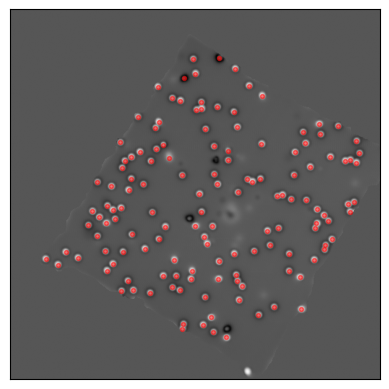

In [125]:
# Display detected atoms
plt.scatter(training_coordinates[:,0],training_coordinates[:,1],s=8,c='r',alpha = 0.5)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.imshow(expdata, cmap = 'gray')

In [126]:
# Initialize GMM random state for reproducible results
class_1_counts = []
class_2_counts = []

# Train the GMM for 100 iterations to find the most probable classification
for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec = training_data.reshape(d0,d1*d2)
    classes = clf.fit_predict(X_vec) +1

    cl_all = []
    for i in range(np.amax(classes)):
        cl = training_data[classes == i + 1]
        cl_all.append(cl)

    class_1_counts.append(len(cl_all[0]))
    class_2_counts.append(len(cl_all[1]))

class_1_counts = np.array(class_1_counts)
class_2_counts = np.array(class_2_counts)
possible_distributions = np.concatenate((class_1_counts,class_2_counts))

In [127]:
most_frequent_distribution = np.bincount(possible_distributions).argmax()
if most_frequent_distribution in class_1_counts:
    random_state_choice = np.where(class_1_counts == most_frequent_distribution)[0][0]
else:
    random_state_choice = np.where(class_2_counts == most_frequent_distribution)[0][0]

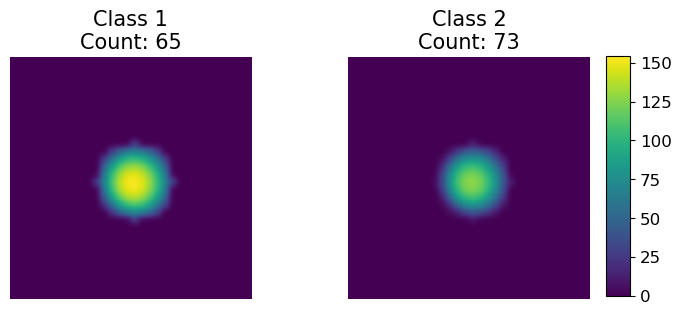

In [128]:
# Initial GMM to classify Fe and Ti atoms in two seperate classes
window_size = 32
n_components = 2
covariance = 'diag'
random_state = random_state_choice
clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec = training_data.reshape(d0,d1*d2)
classes = clf.fit_predict(X_vec) +1
cla = np.ndarray(shape=(
    np.amax(classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)

cl_all = []
vmin, vmax = np.inf, -np.inf
for i in range(np.amax(classes)):
    cl = training_data[classes == i + 1]
    cl_all.append(cl)
    cla[i] = np.mean(cl, axis=0)
    vmin = min(vmin, cla[i].min())
    vmax = max(vmax, cla[i].max())

for i in range(np.amax(classes)):
    ax = fig.add_subplot(gs[i])
    plot = ax.imshow(cla[i, :, :], cmap='viridis',
            interpolation='Gaussian', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'Class {i+1}\nCount: {len(cl_all[i])}', fontsize=15)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.03, 0.6])
colorbar = plt.colorbar(plot, cax=cbar_ax)
colorbar.ax.tick_params(labelsize=12)    
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

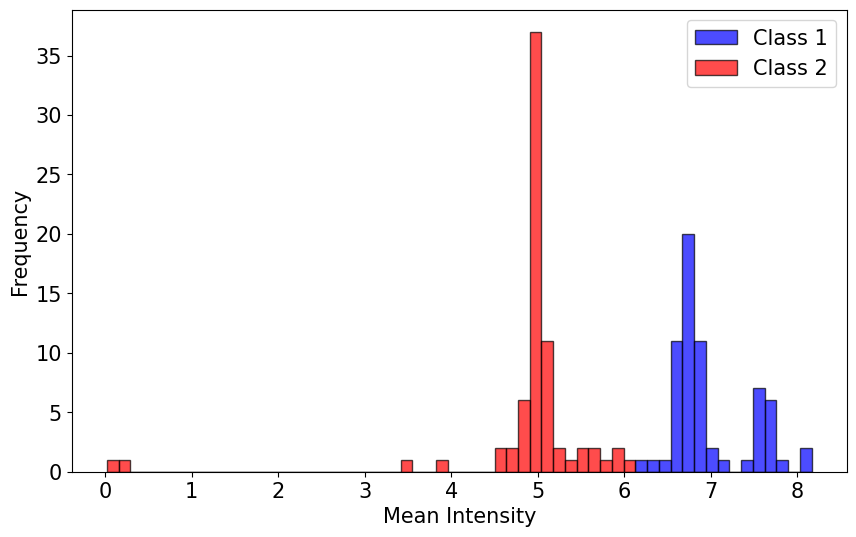

In [129]:
# Plot the distribution of mean intensities within each class
class_labels = np.unique(classes)

class_1_indices = np.where(classes == class_labels[0])
class_2_indices = np.where(classes == class_labels[1])

class_1_average_intensities = np.mean(training_data[class_1_indices], axis = (1,2))
class_2_average_intensities = np.mean(training_data[class_2_indices], axis = (1,2))

all_intensities = np.concatenate([class_1_average_intensities, class_2_average_intensities])
bins = np.histogram_bin_edges(all_intensities, bins=60)

plt.figure(figsize=(10, 6))
plt.hist(class_1_average_intensities, bins=bins, alpha=0.7, label='Class 1', color='blue', edgecolor='black')
plt.hist(class_2_average_intensities, bins=bins, alpha=0.7, label='Class 2', color='red', edgecolor='black')
plt.xlabel('Mean Intensity', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [130]:
# Upload ground truth file
ground_truth_csv_file = 'truth_tables_final/Topo A001.csv' 
ground_truth_df = pd.read_csv(ground_truth_csv_file)
ground_truth_df = ground_truth_df.fillna("D")
ground_truth_df = ground_truth_df.to_numpy(dtype = object)

In [131]:
# Process ground truth file
sorted_indices = np.argsort(training_coordinates[:,0])
sorted_ground_truth_df = np.empty(ground_truth_df.shape, dtype = object)
for i in range(ground_truth_df.shape[0]):
    sorted_ground_truth_df[sorted_indices[i]] = ground_truth_df[i]
sorted_ground_labels = sorted_ground_truth_df[:,-1]
ground_labels, ground_numeric = np.unique(sorted_ground_labels, return_inverse=True)
ground_numeric[np.where((ground_numeric == 0) | (ground_numeric == 1))] = 1 - ground_numeric[np.where((ground_numeric == 0) | (ground_numeric == 1))]

In [132]:
# Set legend for ground truth labeling 
import matplotlib.patches as mpatches
import matplotlib as mpl

cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0,1,3))
legend_elements = [mpatches.Patch(color = colors[0], label = "Fe"),
                   mpatches.Patch(color = colors[1], label = "D"),
                   mpatches.Patch(color = colors[2], label = "Ti")
]

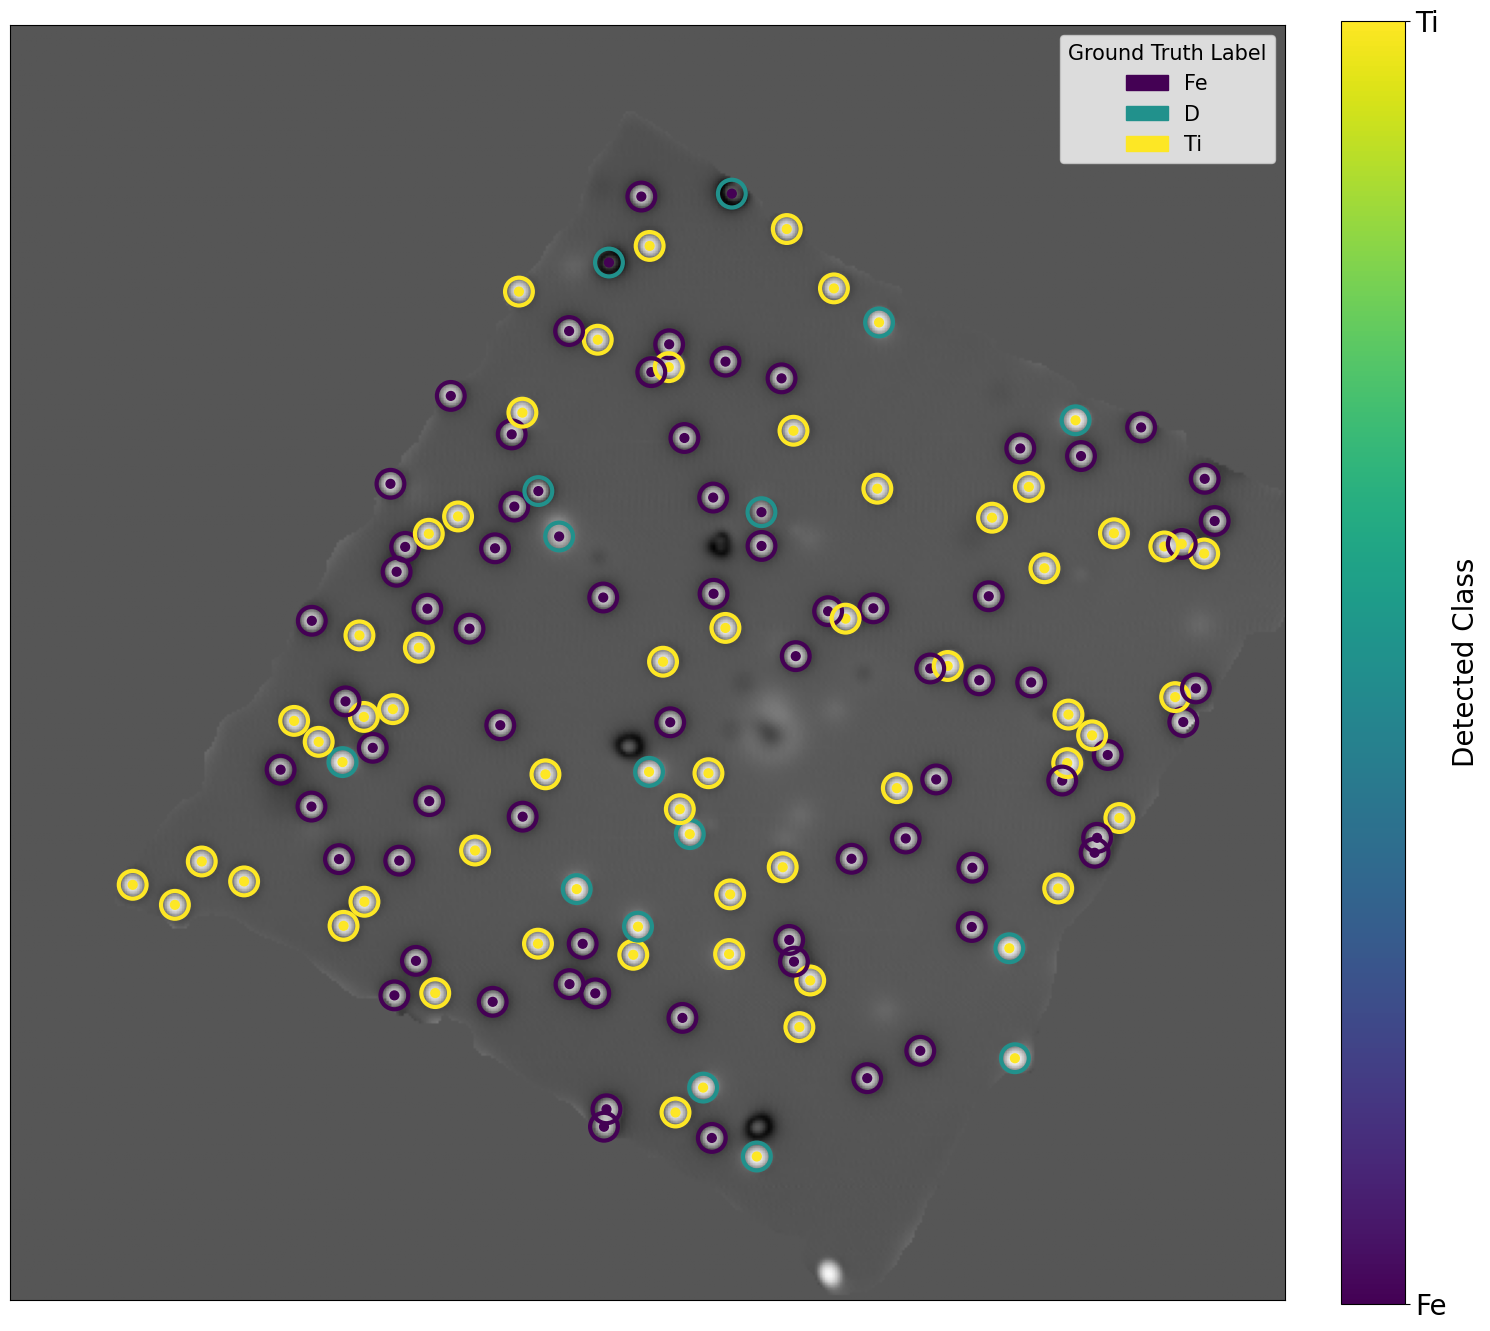

In [133]:
# Plot the results of the intial GMM
import matplotlib.colors as mcolors

atom_classes = classes.astype(object)
if np.min(class_1_average_intensities) < np.min(class_2_average_intensities):
    atom_classes[atom_classes == 1] = "Fe"
    atom_classes[atom_classes == 2] = "Ti"

else:
    atom_classes[atom_classes == 2] = "Fe"
    atom_classes[atom_classes == 1] = "Ti"

class_labels, class_numeric = np.unique(atom_classes, return_inverse=True)

cir_colors = mcolors.Normalize(vmin=np.min(ground_numeric), vmax=np.max(ground_numeric))
edge_colors = plt.cm.viridis(cir_colors(ground_numeric))

plt.figure(figsize=(15, 15))
sc = plt.scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=class_numeric, s=40,
            cmap="viridis")
cir = plt.scatter(training_coordinates[:, 0], training_coordinates[:, 1], s=400, linewidth=3,
            edgecolors=edge_colors,facecolors='none')
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.set_ticks(np.arange(len(class_labels)))
cbar.set_ticklabels(class_labels)
cbar.ax.tick_params(labelsize=20)
cbar.set_label("Detected Class", fontsize = 20)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.legend(handles = legend_elements, fontsize = 15, title = "Ground Truth Label", title_fontsize = 15)
#for i, coord in enumerate(training_coordinates):
#    plt.text(coord[0], coord[1], f'({coord[0]:.2f}, {coord[1]:.2f})', fontsize=8, color='black')
plt.tight_layout()
plt.show()

In [134]:
# Build the dataset of Fe- and Ti-classified atoms
Fe_indices = np.where(class_numeric == 0)[0]
Ti_indices = np.where(class_numeric == 1)[0]

Fe_data = training_data[Fe_indices]
Ti_data = training_data[Ti_indices]

Fe_coordinates = training_coordinates[Fe_indices]
Ti_coordinates = training_coordinates[Ti_indices]

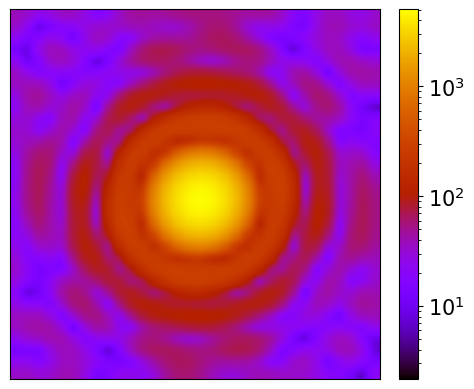

In [135]:
# Perform Fourier transformations on the Fe dataset
from matplotlib.colors import LogNorm

fourier_transformed_fe = np.fft.fft2(Fe_data, axes=(1, 2))
magnitude_fe = np.abs(fourier_transformed_fe)
shifted_fe = np.fft.fftshift(magnitude_fe, axes=(1, 2))
mapped_array_fe = np.zeros_like(Fe_data, dtype=np.float64)
mapped_array_fe[:, :32, :32] = shifted_fe
a, b, c = mapped_array_fe.shape
plt.imshow(mapped_array_fe[0], cmap = 'gnuplot', norm=LogNorm(), interpolation = 'gaussian')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=15)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

In [136]:
# Initialize Fe class-conditioned GMM random state for reproducible results
fe_class_1_counts = []
fe_class_2_counts = []

# Train the Fe class-conditioned GMM for 100 iterations to find the most probable classification
for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    fe_ft_clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec_Fe = mapped_array_fe.reshape(a, b*c)
    fe_ft_classes = fe_ft_clf.fit_predict(X_vec_Fe) +1
    
    fe_ft_cl_all = []
    for i in range(np.amax(fe_ft_classes)):
        fe_ft_cl = mapped_array_fe[fe_ft_classes == i + 1]
        fe_ft_cl_all.append(fe_ft_cl)
        
    fe_class_1_counts.append(len(fe_ft_cl_all[0]))
    fe_class_2_counts.append(len(fe_ft_cl_all[1]))

fe_class_1_counts = np.array(fe_class_1_counts)
fe_class_2_counts = np.array(fe_class_2_counts)
fe_possible_distributions = np.concatenate((fe_class_1_counts,fe_class_2_counts))

In [137]:
fe_most_frequent_distribution = np.bincount(fe_possible_distributions).argmax()
if fe_most_frequent_distribution in fe_class_1_counts:
    fe_random_state_choice = np.where(fe_class_1_counts == fe_most_frequent_distribution)[0][0]
else:
    fe_random_state_choice = np.where(fe_class_2_counts == fe_most_frequent_distribution)[0][0]

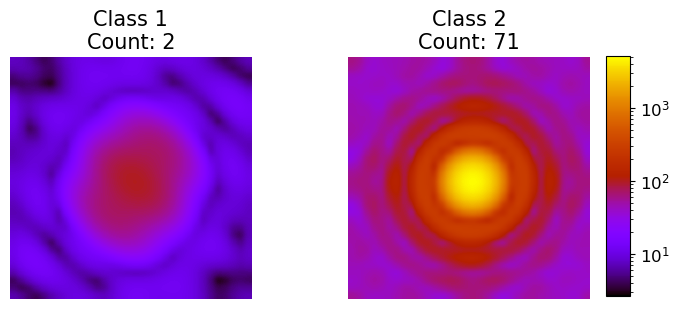

In [138]:
# Fe class-conditioned GMM to seperate true positive Fe sites from defects, unlabeled sites, and misclassifications
window_size = 32
n_components = 2
covariance = 'diag'
random_state = fe_random_state_choice
fe_ft_clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec_Fe = mapped_array_fe.reshape(a, b*c)
fe_ft_classes = fe_ft_clf.fit_predict(X_vec_Fe) +1
fe_ft_cla = np.ndarray(shape=(
    np.amax(fe_ft_classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(fe_ft_classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)

fe_ft_cl_all = []
vmin, vmax = np.inf, -np.inf
for i in range(np.amax(fe_ft_classes)):
    fe_ft_cl = mapped_array_fe[fe_ft_classes == i + 1]
    fe_ft_cl_all.append(fe_ft_cl)
    fe_ft_cla[i] = np.mean(fe_ft_cl, axis=0)
    vmin = min(vmin, fe_ft_cla[i].min())
    vmax = max(vmax, fe_ft_cla[i].max())

for i in range(np.amax(fe_ft_classes)):
    ax = fig.add_subplot(gs[i])
    plot = ax.imshow(fe_ft_cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian', norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.axis('off')
    ax.set_title(f'Class {i+1}\nCount: {len(fe_ft_cl_all[i])}', fontsize=15)
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.03, 0.6])
colorbar = plt.colorbar(plot, cax=cbar_ax)
colorbar.ax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

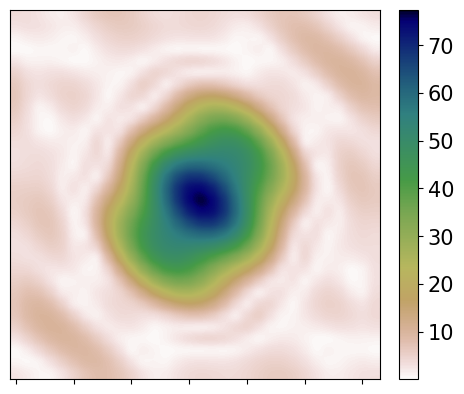

In [139]:
# Plot the class 1 standard deviation to examine the structural differences within the first learned class
fe_class_labels = np.unique(fe_ft_classes)

fe_class_1_indices = np.where(fe_ft_classes == fe_class_labels[0])
fe_class_2_indices = np.where(fe_ft_classes == fe_class_labels[1])

sigma_fe_class_1 = np.std(mapped_array_fe[fe_class_1_indices], axis =0)
fe_ft_figure_1 = plt.figure()
axes = fe_ft_figure_1.add_subplot(111)
caxes = axes.matshow(sigma_fe_class_1, cmap=plt.cm.gist_earth_r, interpolation = 'gaussian')
colorbar = fe_ft_figure_1.colorbar(caxes, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=15)
plt.tick_params(left = False, labelleft = False , 
                labeltop = False, top = False) 

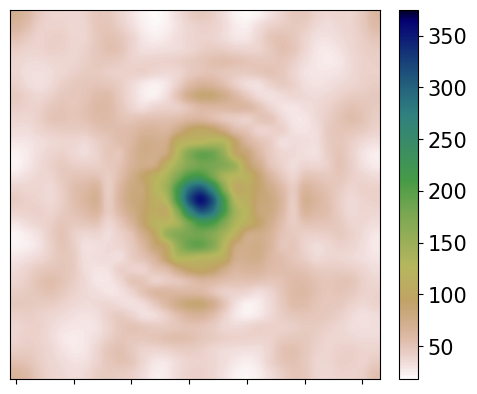

In [140]:
# Plot the class 2 standard deviation to examine the structural differences within the second learned class
sigma_fe_class_2 = np.std(mapped_array_fe[fe_class_2_indices], axis =0)
fe_ft_figure_2 = plt.figure()
axes = fe_ft_figure_2.add_subplot(111)
caxes = axes.matshow(sigma_fe_class_2, cmap=plt.cm.gist_earth_r, interpolation = 'gaussian')
colorbar = fe_ft_figure_2.colorbar(caxes, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=15)
plt.tick_params(left = False, labelleft = False , 
                labeltop = False, top = False) 


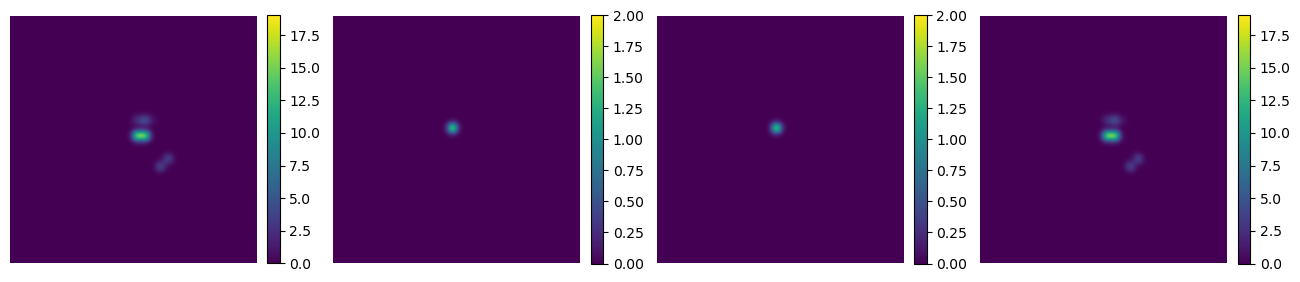

In [141]:
# Sample four random points from class 1 and take their convex hull contour to discover learned features
np.random.seed(2)

rows, cols = 1, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
axes = []

for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

for ax in axes:
    i = np.random.randint(len(Fe_data[fe_class_1_indices]))
    im = Fe_data[fe_class_1_indices][i].copy().astype(np.uint8)
    ret,thresh = cv.threshold(im,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    hull = cv.convexHull(contours[0])
    cv.drawContours(im, [hull], 0, (0, 0, 0), 1)
    
    ax.imshow(im, interpolation='gaussian', origin = 'lower')
    fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

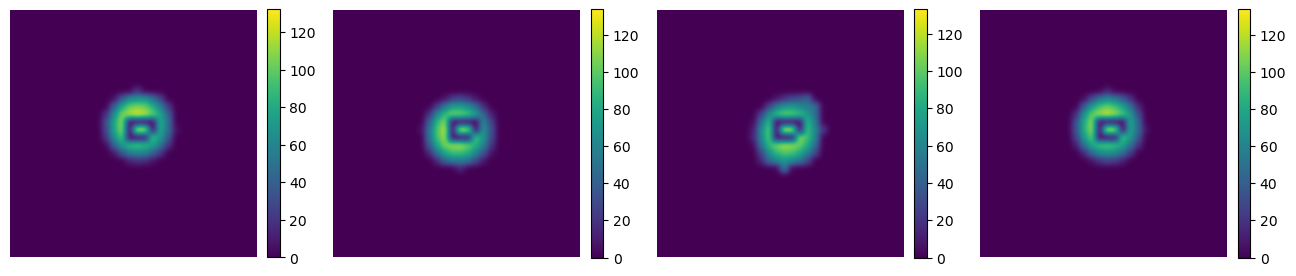

In [142]:
# Sample four random points from class 2 and take their convex hull contour to discover learned features
np.random.seed(5)

rows, cols = 1, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
axes = []

for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

for ax in axes:
    i = np.random.randint(len(Fe_data[fe_class_2_indices]))
    im = Fe_data[fe_class_2_indices][i].copy().astype(np.uint8)
    ret,thresh = cv.threshold(im,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    hull = cv.convexHull(contours[0])
    cv.drawContours(im, [hull], 0, (0, 0, 0), 1)
    
    ax.imshow(im, interpolation='gaussian', origin = 'lower')
    fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

In [143]:
# Upload Fe-classified sites ground truth file
fe_truth_csv_file = 'truth_tables_fe/Topo A001.csv' 
fe_truth_df = pd.read_csv(fe_truth_csv_file)
fe_truth_df = fe_truth_df.to_numpy(dtype = object)

In [144]:
# Process Fe-classified sites ground truth file
sorted_indices = np.argsort(Fe_coordinates[:,0])
sorted_fe_truth_df = np.empty(fe_truth_df.shape, dtype = object)
for i in range(fe_truth_df.shape[0]):
    sorted_fe_truth_df[sorted_indices[i]] = fe_truth_df[i]
sorted_fe_labels = sorted_fe_truth_df[:,-1]
fe_labels, fe_numeric = np.unique(sorted_fe_labels, return_inverse=True)

In [145]:
# Set legend for ground truth labeling  
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0,1,2))
legend_elements = [mpatches.Patch(color = colors[0], label = "D"),
                   mpatches.Patch(color = colors[1], label = "Fe")
]

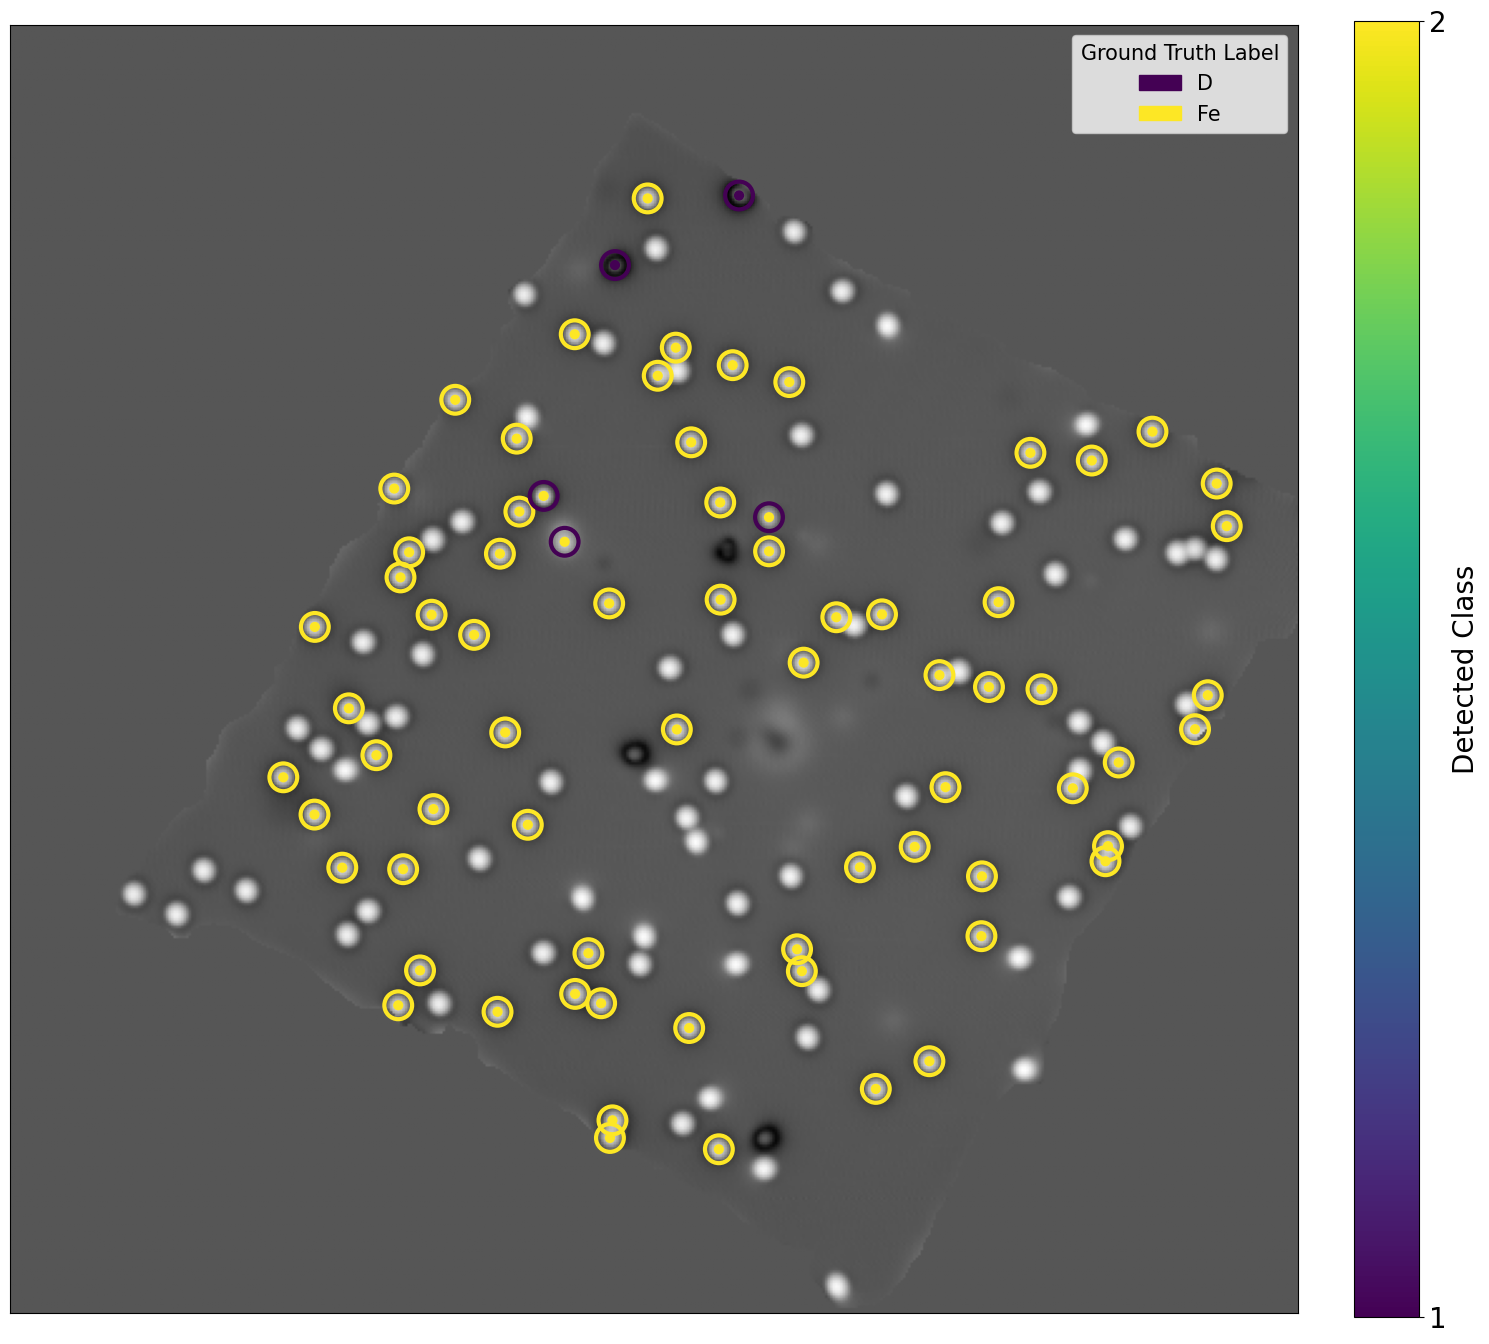

In [146]:
# Plot the results of the Fe class-conditioned GMM
cir_colors = mcolors.Normalize(vmin=np.min(fe_numeric), vmax=np.max(fe_numeric))
edge_colors = plt.cm.viridis(cir_colors(fe_numeric))
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=fe_ft_classes, s=40,
            cmap="viridis")
cir = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], s=400, linewidth=3,
            edgecolors=edge_colors,facecolors='none')
im = plt.imshow(expdata, cmap = 'gray')
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04, ticks = np.unique(fe_ft_classes))
cbar.set_label("Detected Class", fontsize = 20)
cbar.ax.tick_params(labelsize=20)
plt.legend(handles = legend_elements, fontsize = 15, title = "Ground Truth Label", title_fontsize = 15)
plt.tight_layout()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90')])

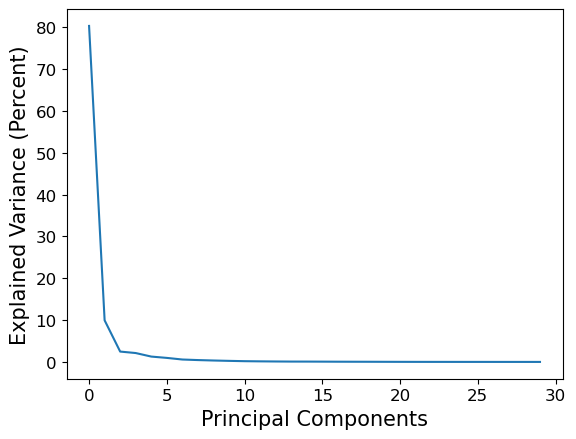

In [147]:
# Plot the explained variance by principal component 
pca = PCA(n_components = 30)
pca_load = pca.fit_transform(X_vec_Fe)
pca_components = pca.components_

plt.plot(np.arange(30), pca.explained_variance_ratio_*100)
#plt.title('Explained Variance by Principle Component')
plt.xlabel('Principal Components', fontsize = 15)
plt.ylabel('Explained Variance (Percent)', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [148]:
pca.explained_variance_ratio_*100

array([8.03e+01, 9.95e+00, 2.48e+00, 2.13e+00, 1.29e+00, 9.71e-01,
       5.85e-01, 4.52e-01, 3.49e-01, 2.63e-01, 1.87e-01, 1.46e-01,
       1.15e-01, 9.29e-02, 8.89e-02, 7.66e-02, 6.24e-02, 5.29e-02,
       4.67e-02, 3.65e-02, 2.84e-02, 2.26e-02, 1.93e-02, 1.77e-02,
       1.58e-02, 1.55e-02, 1.32e-02, 1.23e-02, 1.17e-02, 9.95e-03])

Loading Maps


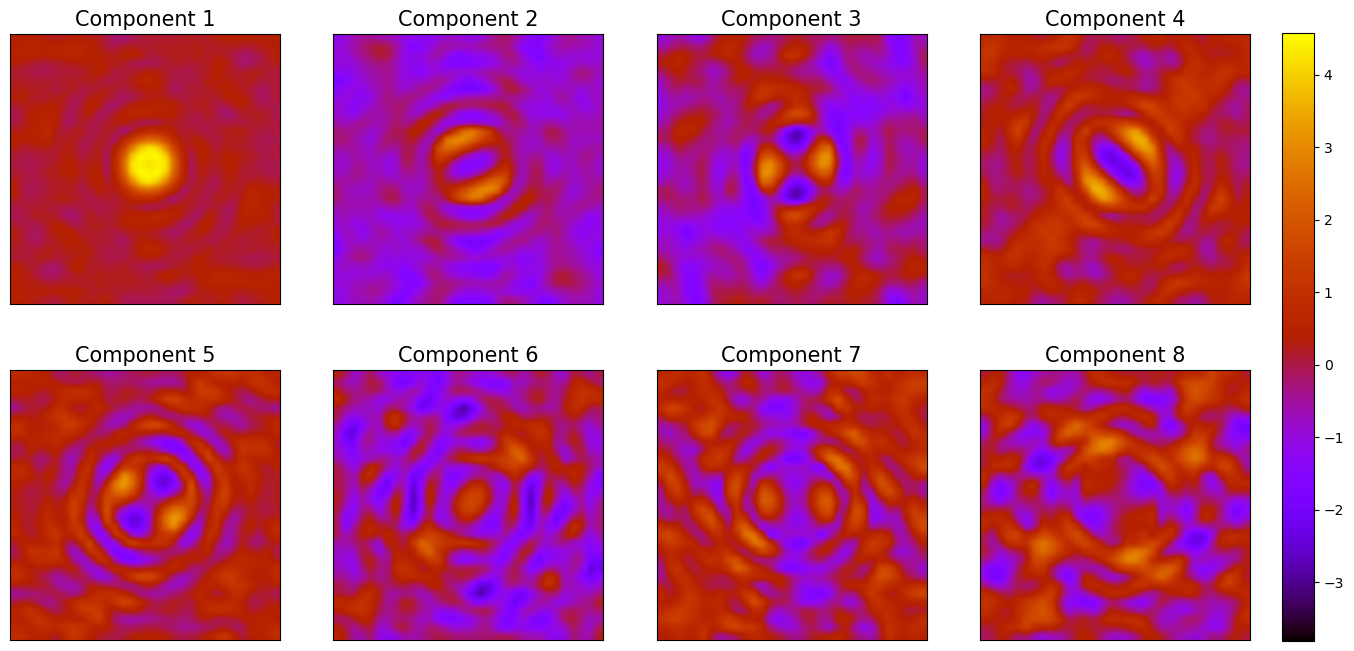

In [149]:
# Plot the learned components to examine the learned sources of variation in each component
from sklearn.preprocessing import StandardScaler

scaled_pca_components = StandardScaler().fit_transform(pca_components)
vmin = scaled_pca_components.min()
vmax = scaled_pca_components.max()
print('Loading Maps')
rows, cols = 2, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
axes = []
for i in range(8):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)
for i, ax in enumerate(axes):
    im = ax.imshow(scaled_pca_components[i,:].reshape(window_size, window_size), vmin = vmin, vmax = vmax, 
                   cmap = 'gnuplot', origin = 'lower', interpolation = 'gaussian')
    ax.set_title('Component ' + str(i+1), fontsize = 15)
    ax.set_xticks([])
    ax.set_yticks([]) 
cbar_ax = fig.add_axes([0.92,0.115,0.02,0.76])
fig.colorbar(im, cax=cbar_ax)
plt.show()

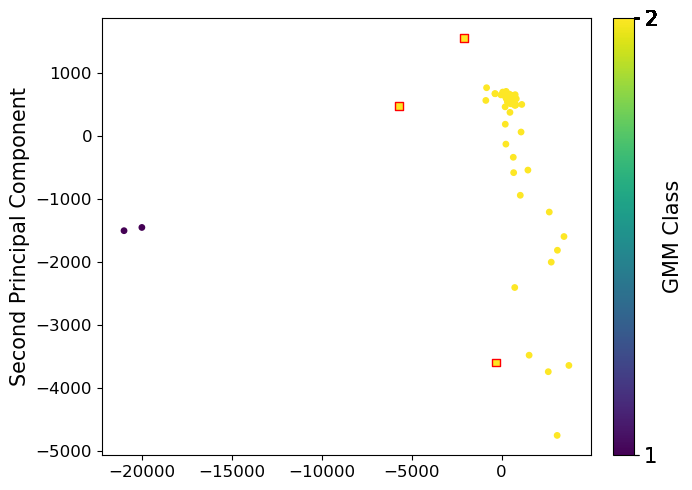

In [150]:
# Plot the two-component PCA space and colorize by the learned Fe-class conditioned GMM classes
error_indices = np.where(fe_ft_classes != (fe_numeric + 1))[0]

fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = fe_ft_classes, cmap = 'viridis', s = 15)
error = ax.scatter(pca_load[error_indices,0], pca_load[error_indices,1], c = fe_ft_classes[error_indices], cmap = 'viridis',
                marker='s', s=30, edgecolors='red', vmin = fe_ft_classes.min(), vmax = fe_ft_classes.max())
#ax.set_xlabel('First Pricinpal Component', fontsize = 15)
ax.set_ylabel('Second Principal Component', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(scatter_plot, ax=ax, ticks = fe_ft_classes, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=15)
cbar.set_label("GMM Class", fontsize = 15)
fig.tight_layout()

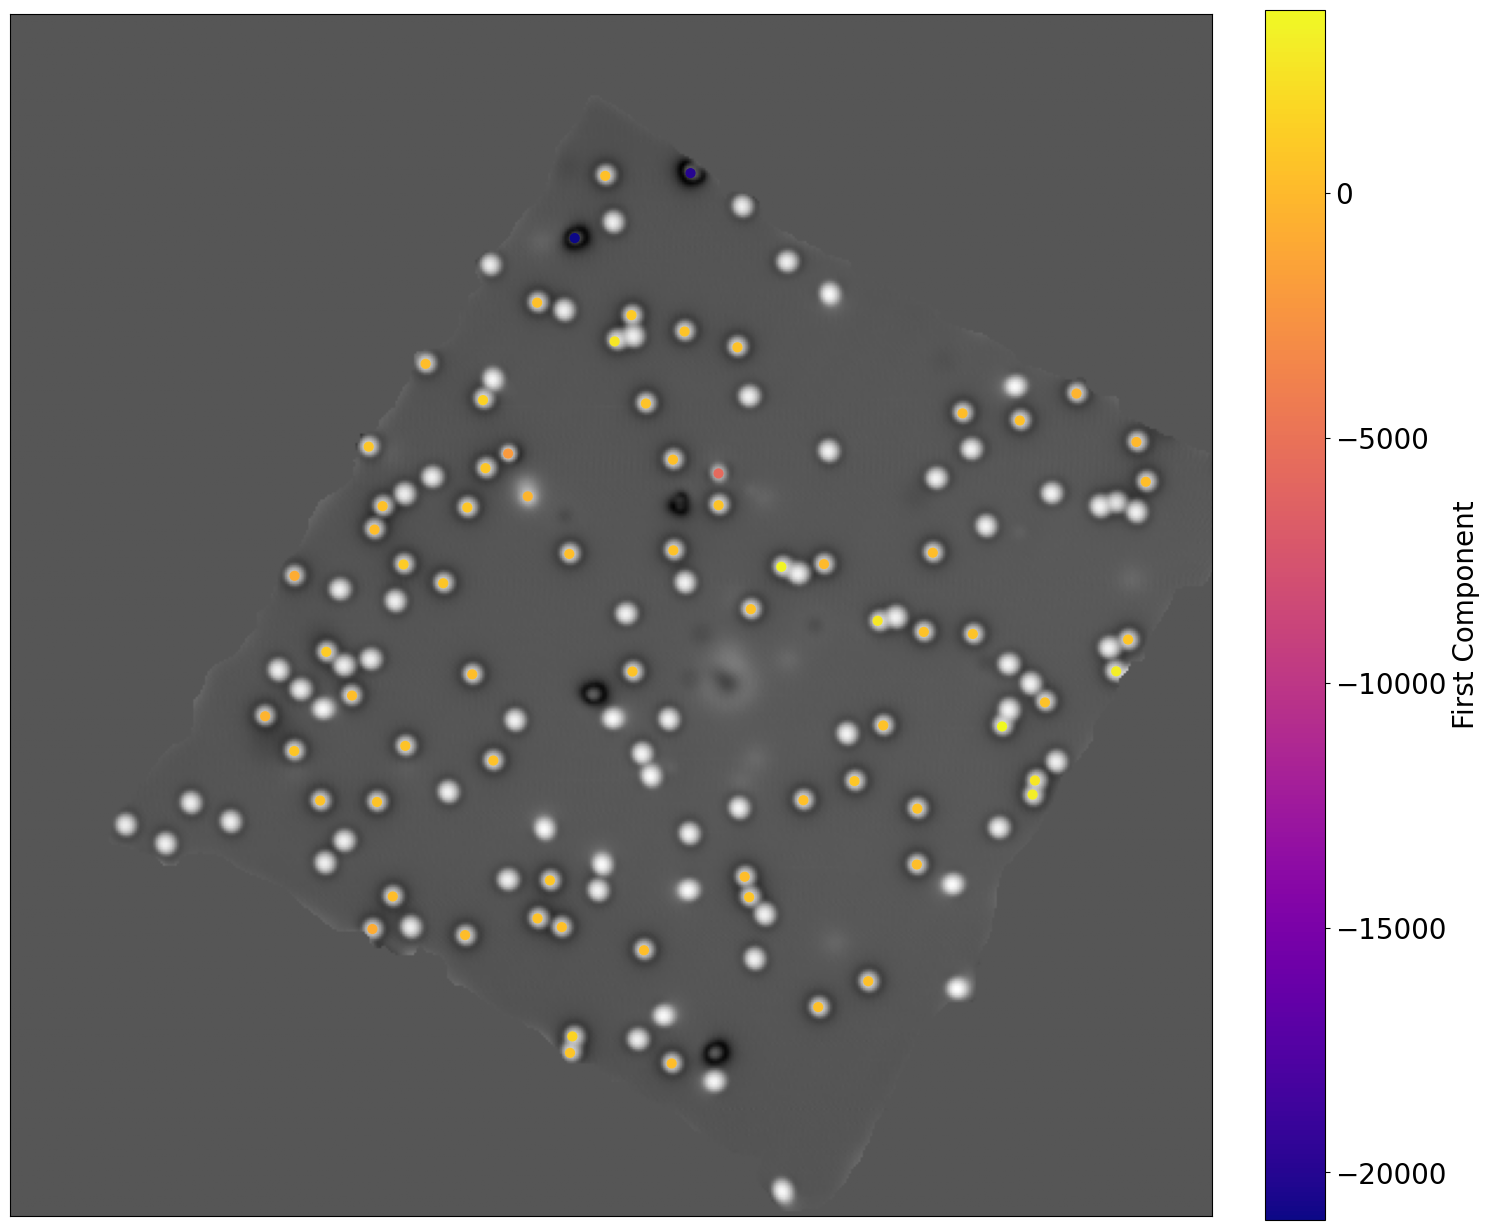

In [151]:
# Project the first principal component onto the Fe-classified data
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=pca_load[:,0], s=40,
            cmap="plasma")
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc,fraction=0.046, pad=0.04)
cbar.set_label("First Component", fontsize = 20)
cbar.ax.tick_params(labelsize=20)
#plt.title("PCA Analysis of Fe Sites: PCA1")
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.tight_layout()
plt.show()

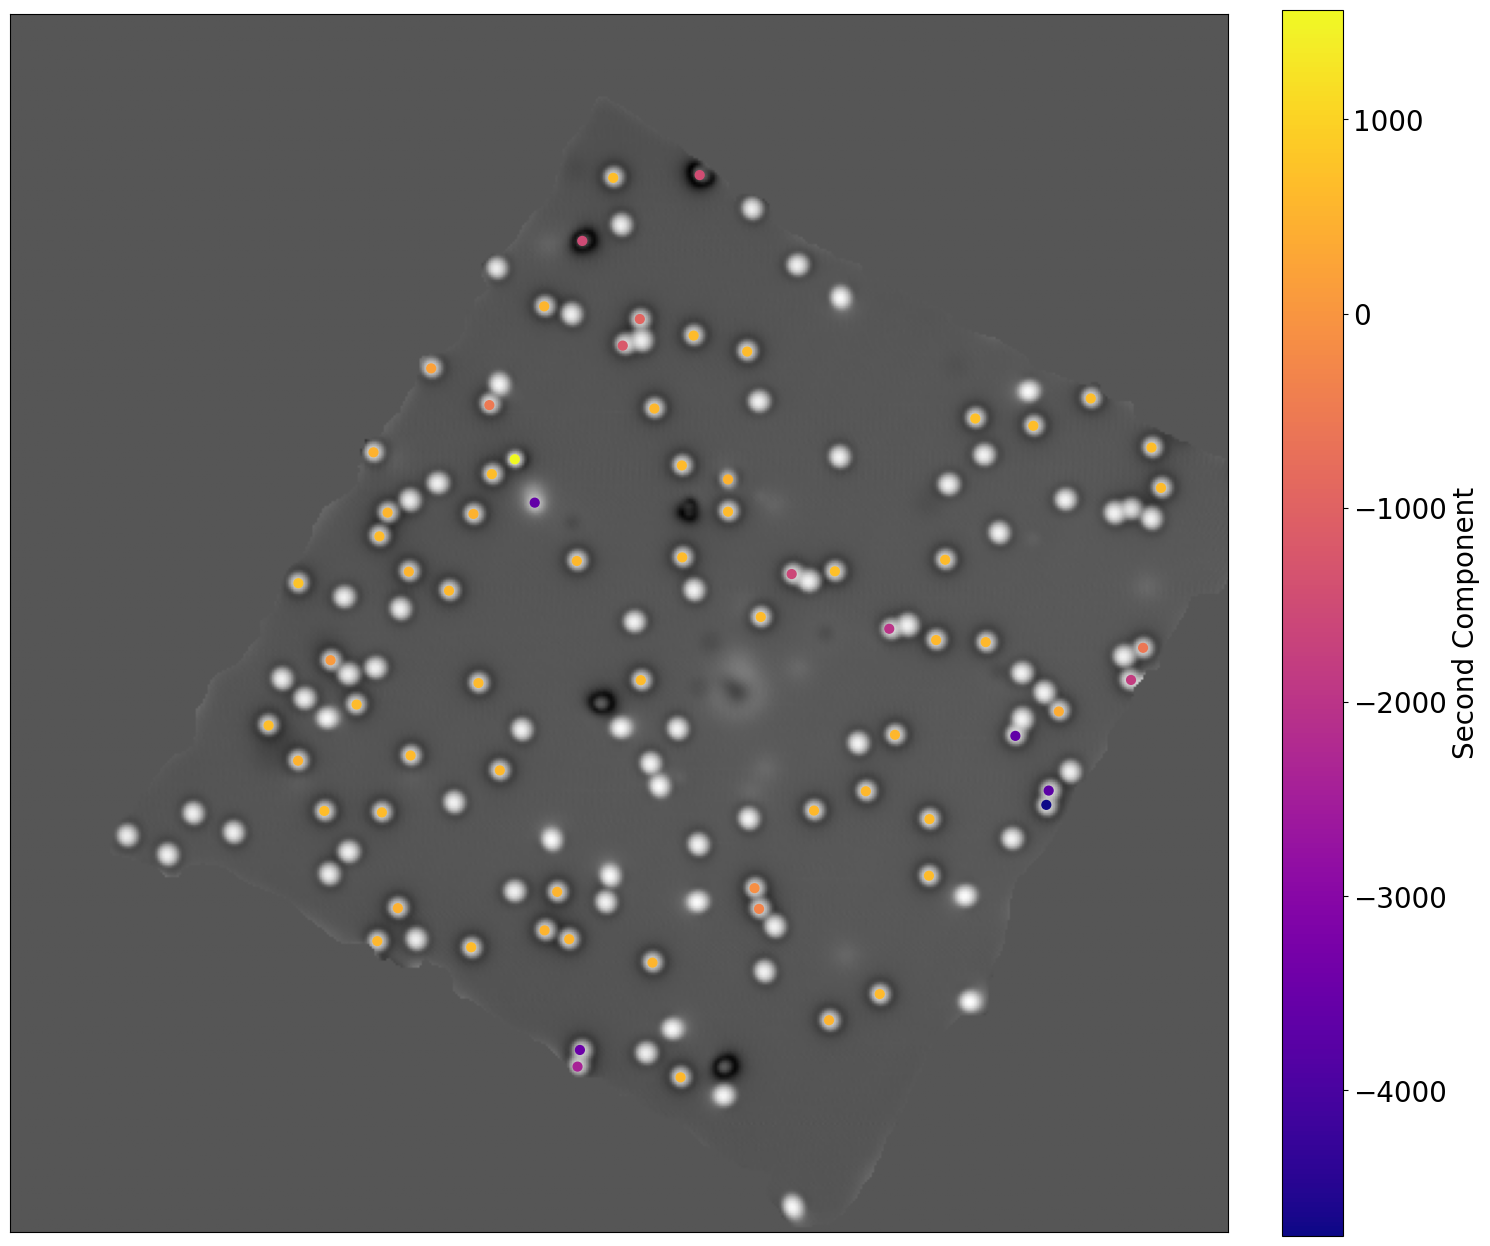

In [152]:
# Project the second principal component onto the Fe-classified data
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=pca_load[:,1], s=40,
            cmap="plasma")
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.set_label("Second Component", fontsize = 20)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
#plt.title("PCA Analysis of Fe Sites: PCA2")
plt.tight_layout()
plt.show()

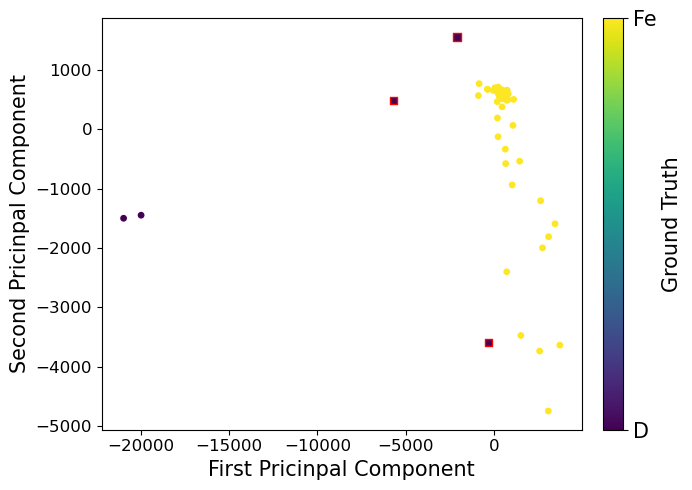

In [153]:
# Plot the two-component PCA space and colorize by the ground truth labeling 
fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = fe_numeric, cmap = 'viridis', s = 15)
error = ax.scatter(pca_load[error_indices,0], pca_load[error_indices,1], c = fe_numeric[error_indices], cmap = 'viridis',
                marker='s', s=30, edgecolors='red', vmin = fe_numeric.min(), vmax = fe_numeric.max())
ax.set_xlabel('First Pricinpal Component', fontsize=15)
ax.set_ylabel('Second Pricinpal Component', fontsize=15)
cbar = plt.colorbar(scatter_plot, ax=ax, fraction=0.046, pad=0.04)
cbar.set_ticks(np.arange(len(fe_labels)))
cbar.set_ticklabels(fe_labels, fontsize = 15)
cbar.set_label("Ground Truth", fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Computation of distances started
Computation of the distances up to 10 NNs started
0.00 seconds for computing distances
ID estimation finished: selecting ID of 7.824994675482744
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished


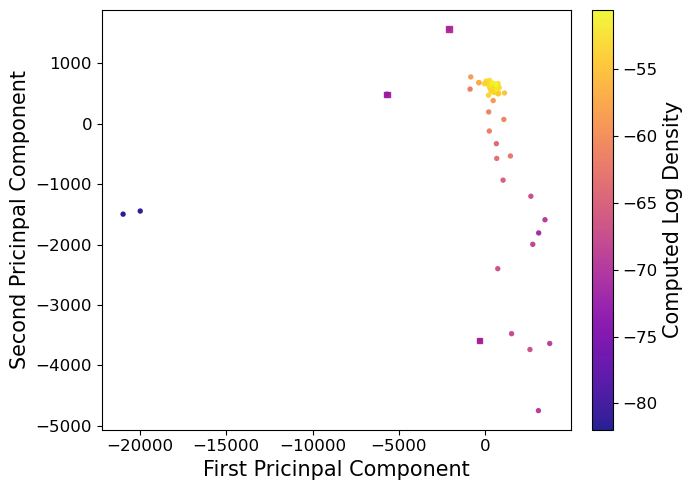

In [154]:
# Find and plot clusters in the data based on the computed density profile of the Fe-class dataset
data = Data(X_vec_Fe, verbose=True)
data.compute_distances(maxk=10)
data.compute_id_2NN()
data.compute_density_kstarNN()
fig, ax = plt.subplots(figsize = (7,5))
ax.set_xlabel('First Pricinpal Component', fontsize = 15)
ax.set_ylabel('Second Pricinpal Component', fontsize = 15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
scatter = ax.scatter(pca_load[:, 0], pca_load[:, 1], s=15.0, alpha=0.9, c=data.log_den, linewidths=0.0, cmap = 'plasma')
error = ax.scatter(pca_load[error_indices,0], pca_load[error_indices,1], c = data.log_den[error_indices],
                marker='s', s=15, alpha = 0.9, cmap = 'plasma', vmin = data.log_den.min(), vmax = data.log_den.max())
cbar = plt.colorbar(scatter, ax=ax,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Computed Log Density", fontsize = 15)
plt.tight_layout()
plt.show()

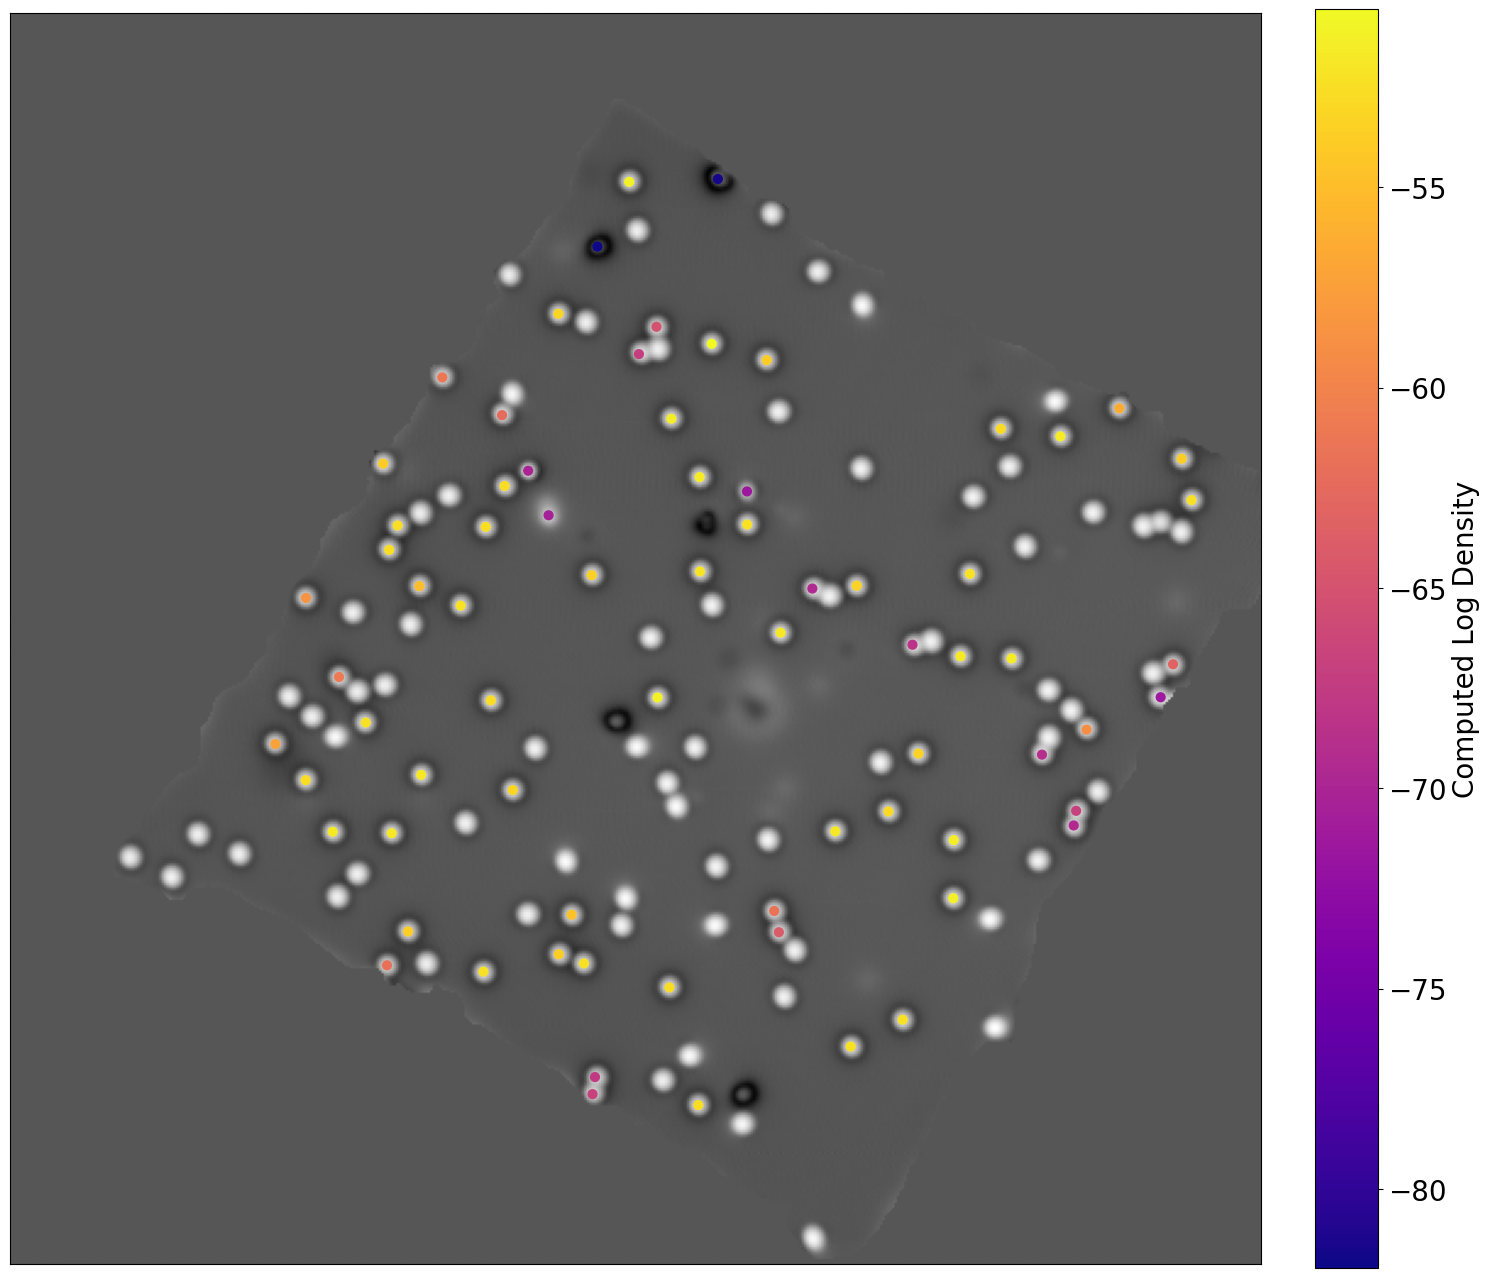

In [155]:
# Project the density-based clustering results on the Fe-classified data
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=data.log_den, s=40,
            cmap="plasma")
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.set_label("Computed Log Density", fontsize = 20)
#plt.title("Density Clustering Results of Ti PCA Space")
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.tight_layout()
plt.show()

In [156]:
# Find the distance of each Fe-classified data point to its nearest neighbour
import math
from scipy.spatial import distance_matrix
import seaborn as sns

Fe_dist_matrix = distance_matrix(training_coordinates, training_coordinates)
Fe_dist_matrix[Ti_indices] = 0
Fe_dist_matrix[Fe_dist_matrix == 0] = np.inf
nearest_neighbours = Fe_dist_matrix.min(axis = 1)
nearest_neighbours = nearest_neighbours[np.isfinite(nearest_neighbours)]

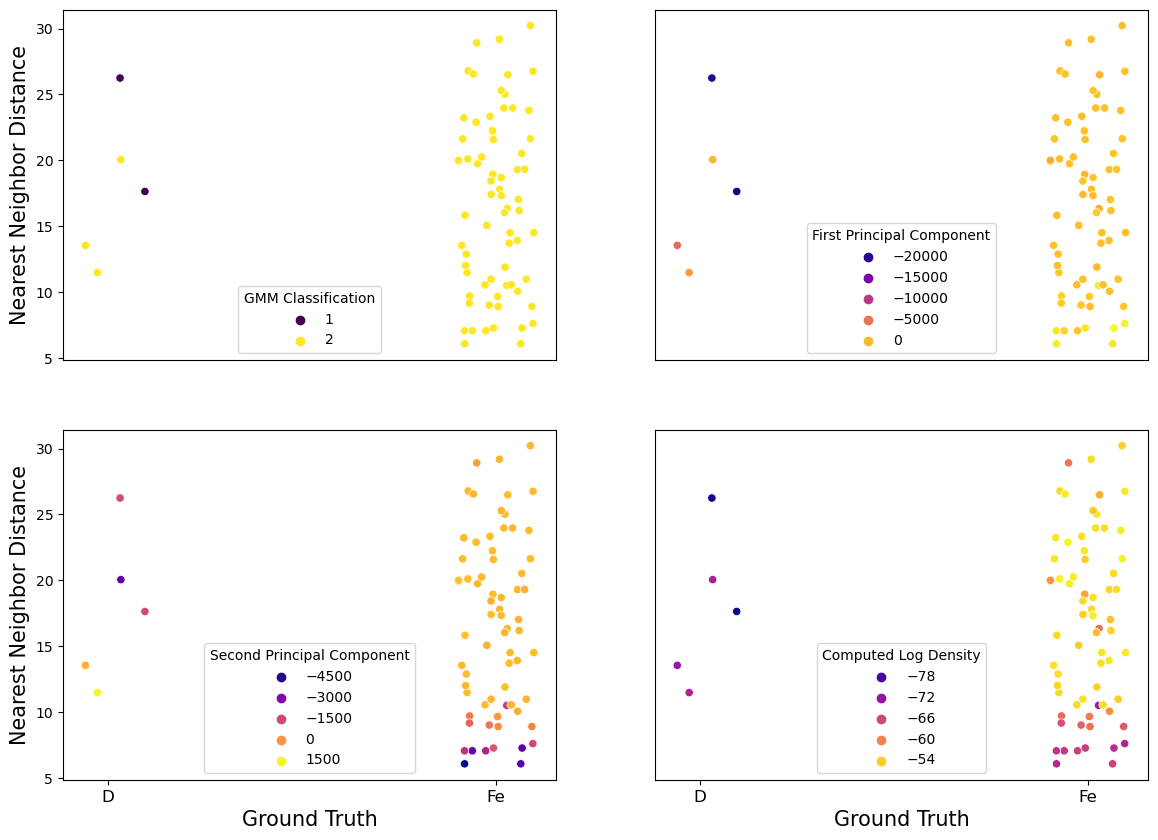

In [157]:
# Plot the nearest neighbour distance against the ground truth labeling colorized by Fe class-conditioned GMM classification,
# the first principal component, the second princpal component, and the density-based clustering results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

np.random.seed(0)
axs[0][0] = sns.scatterplot(x = fe_numeric + np.random.uniform(-0.1, 0.1,len(fe_numeric)), 
                y = nearest_neighbours, hue = fe_ft_classes, 
                palette = 'viridis', ax= axs[0][0])
#axs[0][0].set_xticks(ticks = np.unique(ti_numeric), labels = np.unique(ti_labels), fontsize = 12)
axs[0][0].set_ylabel('Nearest Neighbor Distance', fontsize=15)
handles, labels = axs[0][0].get_legend_handles_labels()
axs[0][0].get_xaxis().set_visible(False)
axs[0][0].legend(handles, labels,  loc='lower center', title = 'GMM Classification')

np.random.seed(0)
axs[0][1] = sns.scatterplot(x = fe_numeric + np.random.uniform(-0.1, 0.1,len(fe_numeric)), 
                y = nearest_neighbours, hue = pca_load[:,0], 
                palette = 'plasma', ax= axs[0][1])
#axs[0][1].set_xticks(ticks = np.unique(ti_numeric), labels = np.unique(ti_labels), fontsize = 12)
axs[0][1].get_yaxis().set_visible(False)
axs[0][1].get_xaxis().set_visible(False)
axs[0][1].legend(title = 'First Principal Component')

np.random.seed(0)
axs[1][0] = sns.scatterplot(x = fe_numeric + np.random.uniform(-0.1, 0.1,len(fe_numeric)), 
                y = nearest_neighbours, hue = pca_load[:,1], 
                palette = 'plasma', ax= axs[1][0])
axs[1][0].set_xticks(ticks = np.unique(fe_numeric), labels = np.unique(fe_labels), fontsize = 12)
axs[1][0].set_ylabel('Nearest Neighbor Distance', fontsize=15)
axs[1][0].set_xlabel('Ground Truth', fontsize=15)
axs[1][0].legend(title = 'Second Principal Component',  loc='lower center')


np.random.seed(0)
axs[1][1] = sns.scatterplot(x = fe_numeric + np.random.uniform(-0.1, 0.1,len(fe_numeric)), 
                y = nearest_neighbours, hue = data.log_den, 
                palette = 'plasma', ax= axs[1][1])
axs[1][1].set_xticks(ticks = np.unique(fe_numeric), labels = np.unique(fe_labels), fontsize = 12)
axs[1][1].set_xlabel('Ground Truth', fontsize=15)
axs[1][1].get_yaxis().set_visible(False)
axs[1][1].legend(title = 'Computed Log Density')

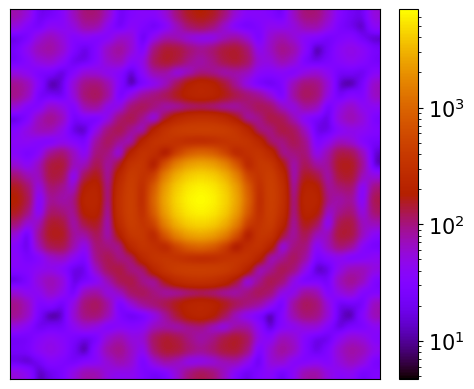

In [158]:
# Perform Fourier transformations on the Ti dataset
fourier_transformed_ti = np.fft.fft2(Ti_data, axes=(1, 2))
magnitude_ti = np.abs(fourier_transformed_ti)
shifted_ti = np.fft.fftshift(magnitude_ti, axes=(1, 2))
mapped_array_ti = np.zeros_like(Ti_data, dtype=np.float64)
mapped_array_ti[:, :32, :32] = shifted_ti
a, b, c = mapped_array_ti.shape
plt.imshow(mapped_array_ti[1], cmap = 'gnuplot', norm=LogNorm(), interpolation = 'gaussian')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize = 15)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

In [159]:
# Initialize Ti class-conditioned GMM random state for reproducible results
ti_class_1_counts = []
ti_class_2_counts = []

# Train the Ti class-conditioned GMM for 100 iterations to find the most probable classification
for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    ti_ft_clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec_Ti = mapped_array_ti.reshape(a, b*c)
    ti_ft_classes = ti_ft_clf.fit_predict(X_vec_Ti) +1

    ti_ft_cl_all = []
    for i in range(np.amax(ti_ft_classes)):
        ti_ft_cl = mapped_array_ti[ti_ft_classes == i + 1]
        ti_ft_cl_all.append(ti_ft_cl)

    ti_class_1_counts.append(len(ti_ft_cl_all[0]))
    ti_class_2_counts.append(len(ti_ft_cl_all[1]))

ti_class_1_counts = np.array(ti_class_1_counts)
ti_class_2_counts = np.array(ti_class_2_counts)
ti_possible_distributions = np.concatenate((ti_class_1_counts,ti_class_2_counts))

In [160]:
ti_most_frequent_distribution = np.bincount(ti_possible_distributions).argmax()
if ti_most_frequent_distribution in ti_class_1_counts:
    ti_random_state_choice = np.where(ti_class_1_counts == ti_most_frequent_distribution)[0][0]
else:
    ti_random_state_choice = np.where(ti_class_2_counts == ti_most_frequent_distribution)[0][0]

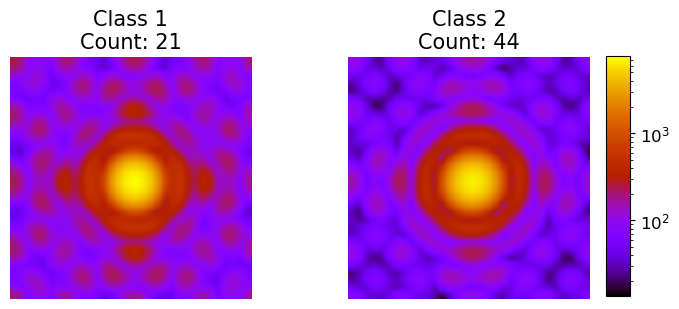

In [161]:
# Ti class-conditioned GMM to seperate true positive Fe sites from defects, unlabeled sites, and misclassifications
window_size = 32
n_components = 2
covariance = 'diag'
random_state = ti_random_state_choice
ti_ft_clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec_Ti = mapped_array_ti.reshape(a, b*c)
ti_ft_classes = ti_ft_clf.fit_predict(X_vec_Ti) +1
ti_ft_cla = np.ndarray(shape=(
    np.amax(ti_ft_classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(ti_ft_classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)

ti_ft_cl_all = []
vmin, vmax = np.inf, -np.inf
for i in range(np.amax(ti_ft_classes)):
    ti_ft_cl = mapped_array_ti[ti_ft_classes == i + 1]
    ti_ft_cl_all.append(ti_ft_cl)
    ti_ft_cla[i] = np.mean(ti_ft_cl, axis=0)
    vmin = min(vmin, ti_ft_cla[i].min())
    vmax = max(vmax, ti_ft_cla[i].max())

for i in range(np.amax(ti_ft_classes)):
    ax = fig.add_subplot(gs[i])
    plot = ax.imshow(ti_ft_cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian', norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.axis('off')
    ax.set_title(f'Class {i+1}\nCount: {len(ti_ft_cl_all[i])}', fontsize=15)
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.03, 0.6])
colorbar = plt.colorbar(plot, cax=cbar_ax)
colorbar.ax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

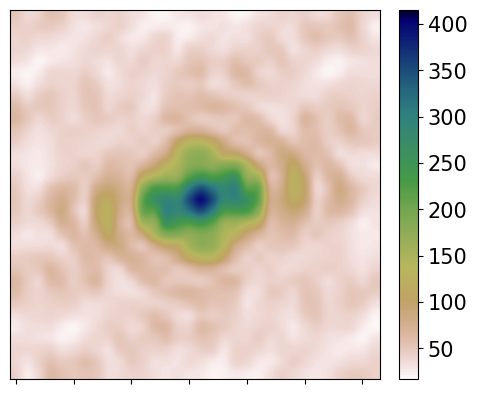

In [162]:
# Plot the class 1 standard deviation to examine the structural differences within the first learned class
ti_class_labels = np.unique(ti_ft_classes)

ti_class_1_indices = np.where(ti_ft_classes == ti_class_labels[0])
ti_class_2_indices = np.where(ti_ft_classes == ti_class_labels[1])

sigma_ti_class_1 = np.std(mapped_array_ti[ti_class_1_indices], axis =0)
ti_ft_figure_1 = plt.figure()
axes = ti_ft_figure_1.add_subplot(111)
caxes = axes.matshow(sigma_ti_class_1, cmap=plt.cm.gist_earth_r, interpolation = 'gaussian')
colorbar = ti_ft_figure_1.colorbar(caxes, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=15)
plt.tick_params(left = False, labelleft = False , 
                labeltop = False, top = False) 

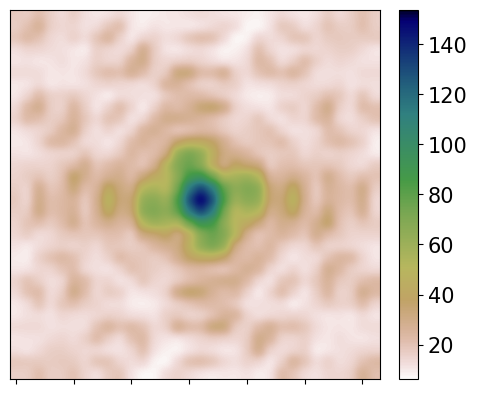

In [163]:
# Plot the class 2 standard deviation to examine the structural differences within the second learned class
sigma_ti_class_2 = np.std(mapped_array_ti[ti_class_2_indices], axis =0)
ti_ft_figure_2 = plt.figure()
axes = ti_ft_figure_2.add_subplot(111)
caxes = axes.matshow(sigma_ti_class_2, cmap=plt.cm.gist_earth_r, interpolation = 'gaussian')
colorbar = ti_ft_figure_2.colorbar(caxes, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=15)
plt.tick_params(left = False, labelleft = False , 
                labeltop = False, top = False) 

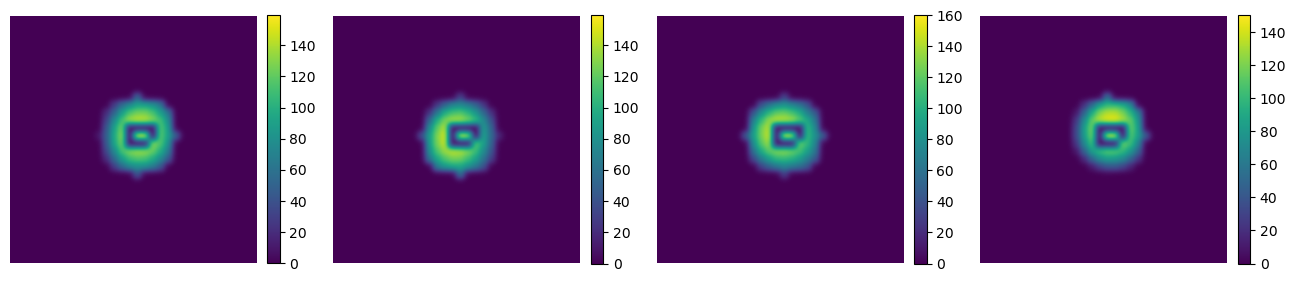

In [164]:
# Sample four random points from class 1 and take their convex hull contour to discover learned features
np.random.seed(4)

rows, cols = 1, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
axes = []

for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

for ax in axes:
    i = np.random.randint(len(Ti_data[ti_class_1_indices]))
    im = Ti_data[ti_class_1_indices][i].copy().astype(np.uint8)
    ret,thresh = cv.threshold(im,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    hull = cv.convexHull(contours[0])
    cv.drawContours(im, [hull], 0, (0, 0, 0), 1)
    
    ax.imshow(im, interpolation='gaussian', origin = 'lower')
    fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

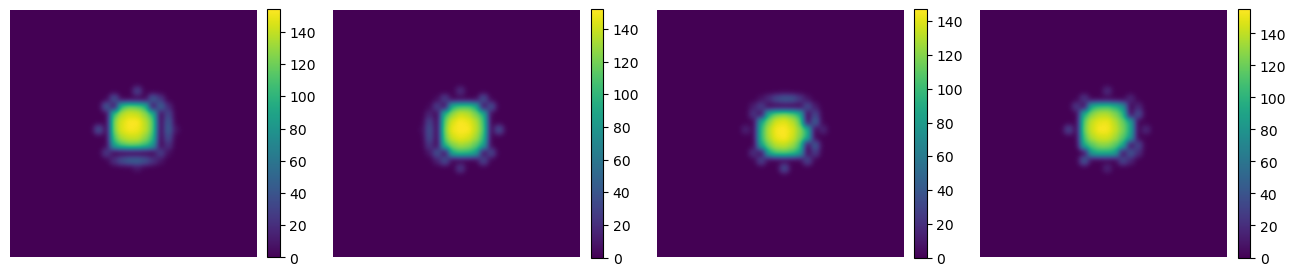

In [165]:
# Sample four random points from class 2 and take their convex hull contour to discover learned features
np.random.seed(4)

rows, cols = 1, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
axes = []

for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

for ax in axes:
    i = np.random.randint(len(Ti_data[ti_class_2_indices]))
    im = Ti_data[ti_class_2_indices][i].copy().astype(np.uint8)
    ret,thresh = cv.threshold(im,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    hull = cv.convexHull(contours[0])
    cv.drawContours(im, [hull], 0, (0, 0, 0), 1)
    
    ax.imshow(im, interpolation='gaussian', origin = 'lower')
    fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')

In [166]:
# Upload Ti-classified sites ground truth file
ti_truth_csv_file = 'truth_tables_ti/Topo A001.csv'  
ti_truth_df = pd.read_csv(ti_truth_csv_file)
ti_truth_df = ti_truth_df.to_numpy(dtype = object)

In [167]:
# Process Ti-classified sites ground truth file
sorted_indices = np.argsort(Ti_coordinates[:,0])
sorted_ti_truth_df = np.empty(ti_truth_df.shape, dtype = object)
for i in range(ti_truth_df.shape[0]):
    sorted_ti_truth_df[sorted_indices[i]] = ti_truth_df[i]
sorted_ti_labels = sorted_ti_truth_df[:,-1]
ti_labels, ti_numeric = np.unique(sorted_ti_labels, return_inverse=True)

In [168]:
# Set legend for ground truth labeling  
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0,1,2))
legend_elements = [mpatches.Patch(color = colors[0], label = "D"),
                   mpatches.Patch(color = colors[1], label = "Ti")
]

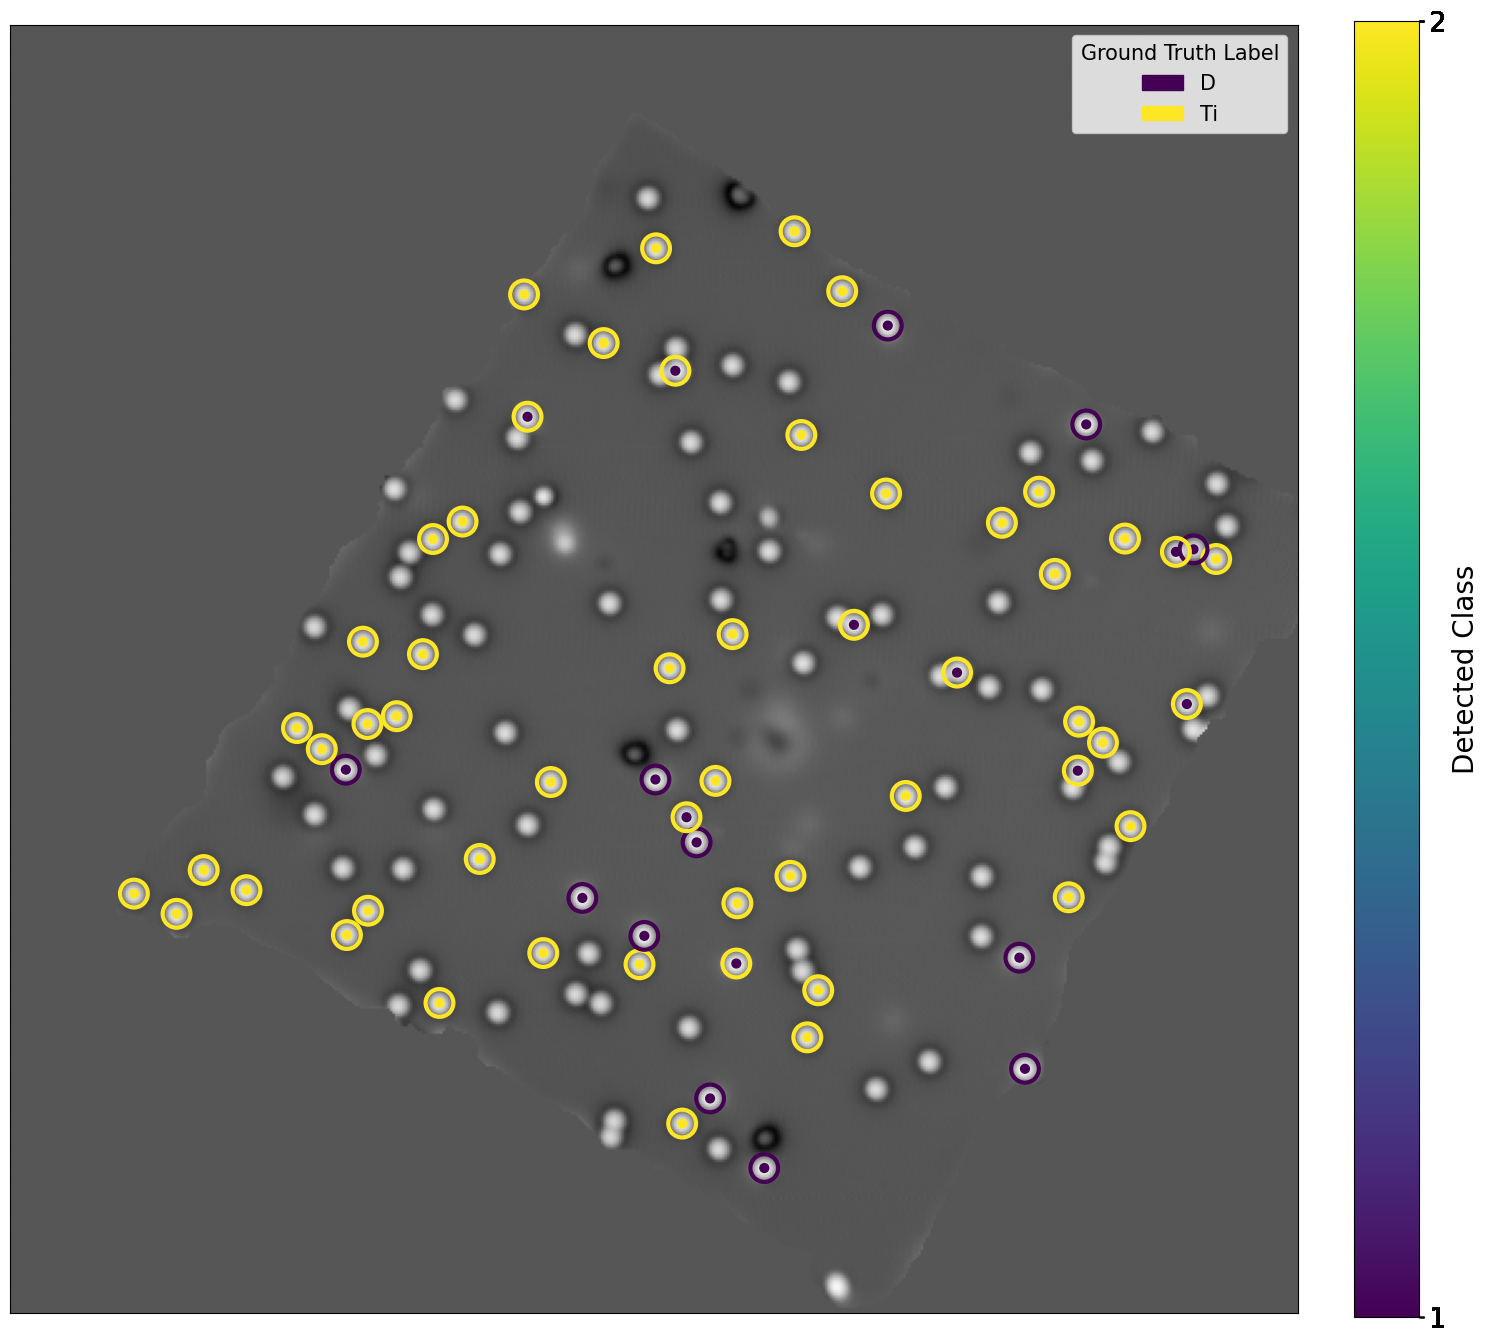

In [169]:
# Plot the results of the Ti class-conditioned GMM
cir_colors = mcolors.Normalize(vmin=np.min(ti_numeric), vmax=np.max(ti_numeric))
edge_colors = plt.cm.viridis(cir_colors(ti_numeric))
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=ti_ft_classes, s=40,
            cmap="viridis")
cir = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], s=400, linewidth = 3,
            edgecolors=edge_colors,facecolors='none')
im = plt.imshow(expdata, cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04, ticks=ti_ft_classes)
cbar.set_label("Detected Class", fontsize = 20)
cbar.ax.tick_params(labelsize=20)
#plt.title('GMM Classification of Ti Sites')
plt.legend(handles = legend_elements, fontsize = 15, title = "Ground Truth Label", title_fontsize = 15)
plt.tight_layout()
plt.show()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70')])

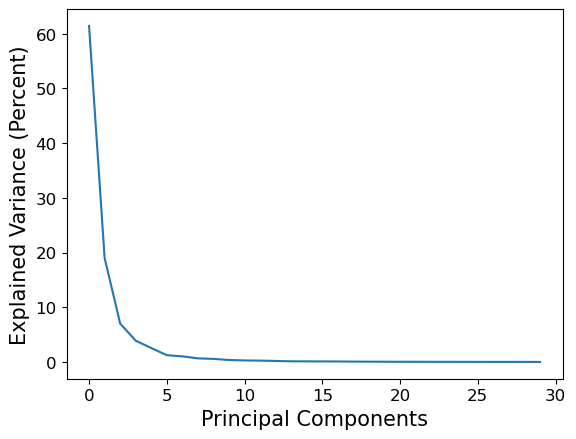

In [170]:
# Plot the explained variance by principal component 
pca = PCA(n_components = 30)
pca_load = pca.fit_transform(X_vec_Ti)
pca_components = pca.components_

plt.plot(np.arange(30), pca.explained_variance_ratio_*100)
#plt.title('Explained Variance by Principal Component')
plt.xlabel('Principal Components', fontsize=15)
plt.ylabel('Explained Variance (Percent)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [171]:
pca.explained_variance_ratio_*100

array([6.14e+01, 1.90e+01, 7.03e+00, 3.90e+00, 2.57e+00, 1.26e+00,
       1.04e+00, 6.75e-01, 5.75e-01, 3.76e-01, 2.96e-01, 2.65e-01,
       2.02e-01, 1.35e-01, 1.28e-01, 1.16e-01, 1.09e-01, 8.05e-02,
       6.73e-02, 6.30e-02, 5.04e-02, 4.78e-02, 4.28e-02, 3.91e-02,
       3.60e-02, 3.30e-02, 3.22e-02, 3.00e-02, 2.82e-02, 2.45e-02])

Loading Maps


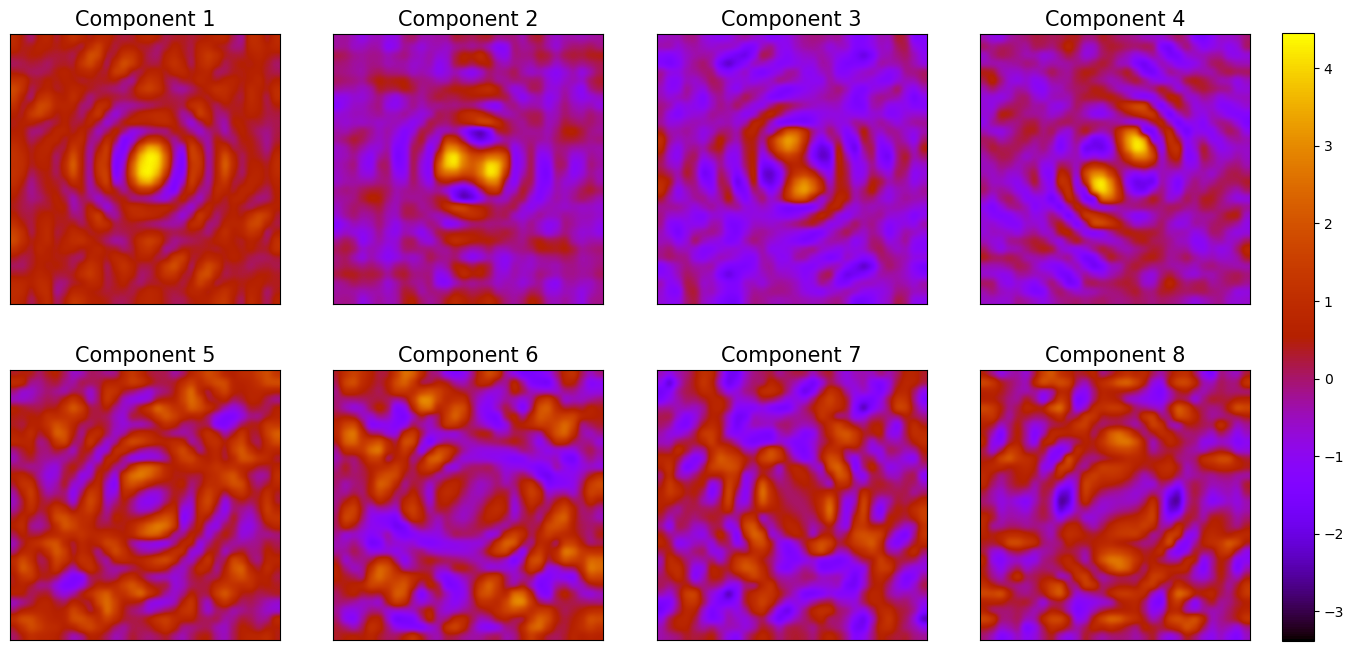

In [172]:
# Plot the learned components to examine the learned sources of variation in each component
from sklearn.preprocessing import StandardScaler

scaled_pca_components = StandardScaler().fit_transform(pca_components)
vmin = scaled_pca_components.min()
vmax = scaled_pca_components.max()
print('Loading Maps')
rows, cols = 2, 4
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
axes = []
for i in range(8):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)
for i, ax in enumerate(axes):
    im = ax.imshow(scaled_pca_components[i,:].reshape(window_size, window_size), vmin = vmin, vmax = vmax, 
                   cmap = 'gnuplot', origin = 'lower', interpolation = 'gaussian')
    ax.set_title('Component ' + str(i+1), fontsize = 15)
    ax.set_xticks([])
    ax.set_yticks([]) 
cbar_ax = fig.add_axes([0.92,0.115,0.02,0.76])
fig.colorbar(im, cax=cbar_ax)
plt.show()

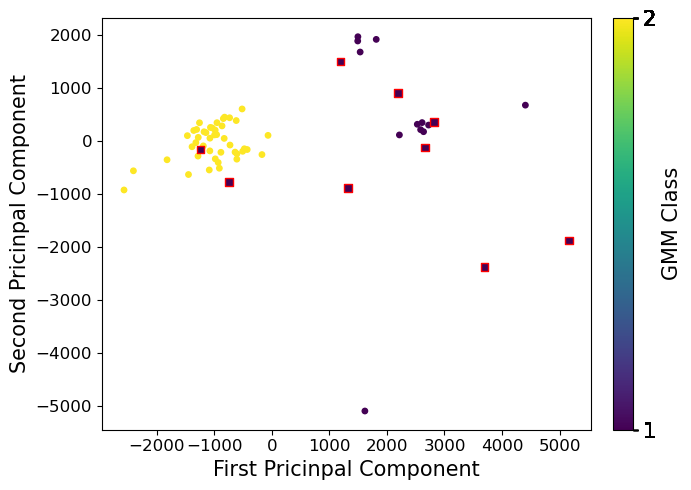

In [173]:
# Plot the two-component PCA space and colorize by the learned Ti-class conditioned GMM classes
error_indices = np.where(ti_ft_classes != (ti_numeric + 1))[0]

fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = ti_ft_classes, cmap = 'viridis', s = 15)
error = ax.scatter(pca_load[error_indices,0], pca_load[error_indices,1], c = ti_ft_classes[error_indices], cmap = 'viridis',
                marker='s', s=30, edgecolors='red', vmin = ti_ft_classes.min(), vmax = ti_ft_classes.max())
ax.set_xlabel('First Pricinpal Component', fontsize = 15)
ax.set_ylabel('Second Pricinpal Component', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(scatter_plot, ax=ax, ticks = ti_ft_classes, fraction=0.046, pad=0.04)
cbar.set_label("GMM Class", fontsize = 15)
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()

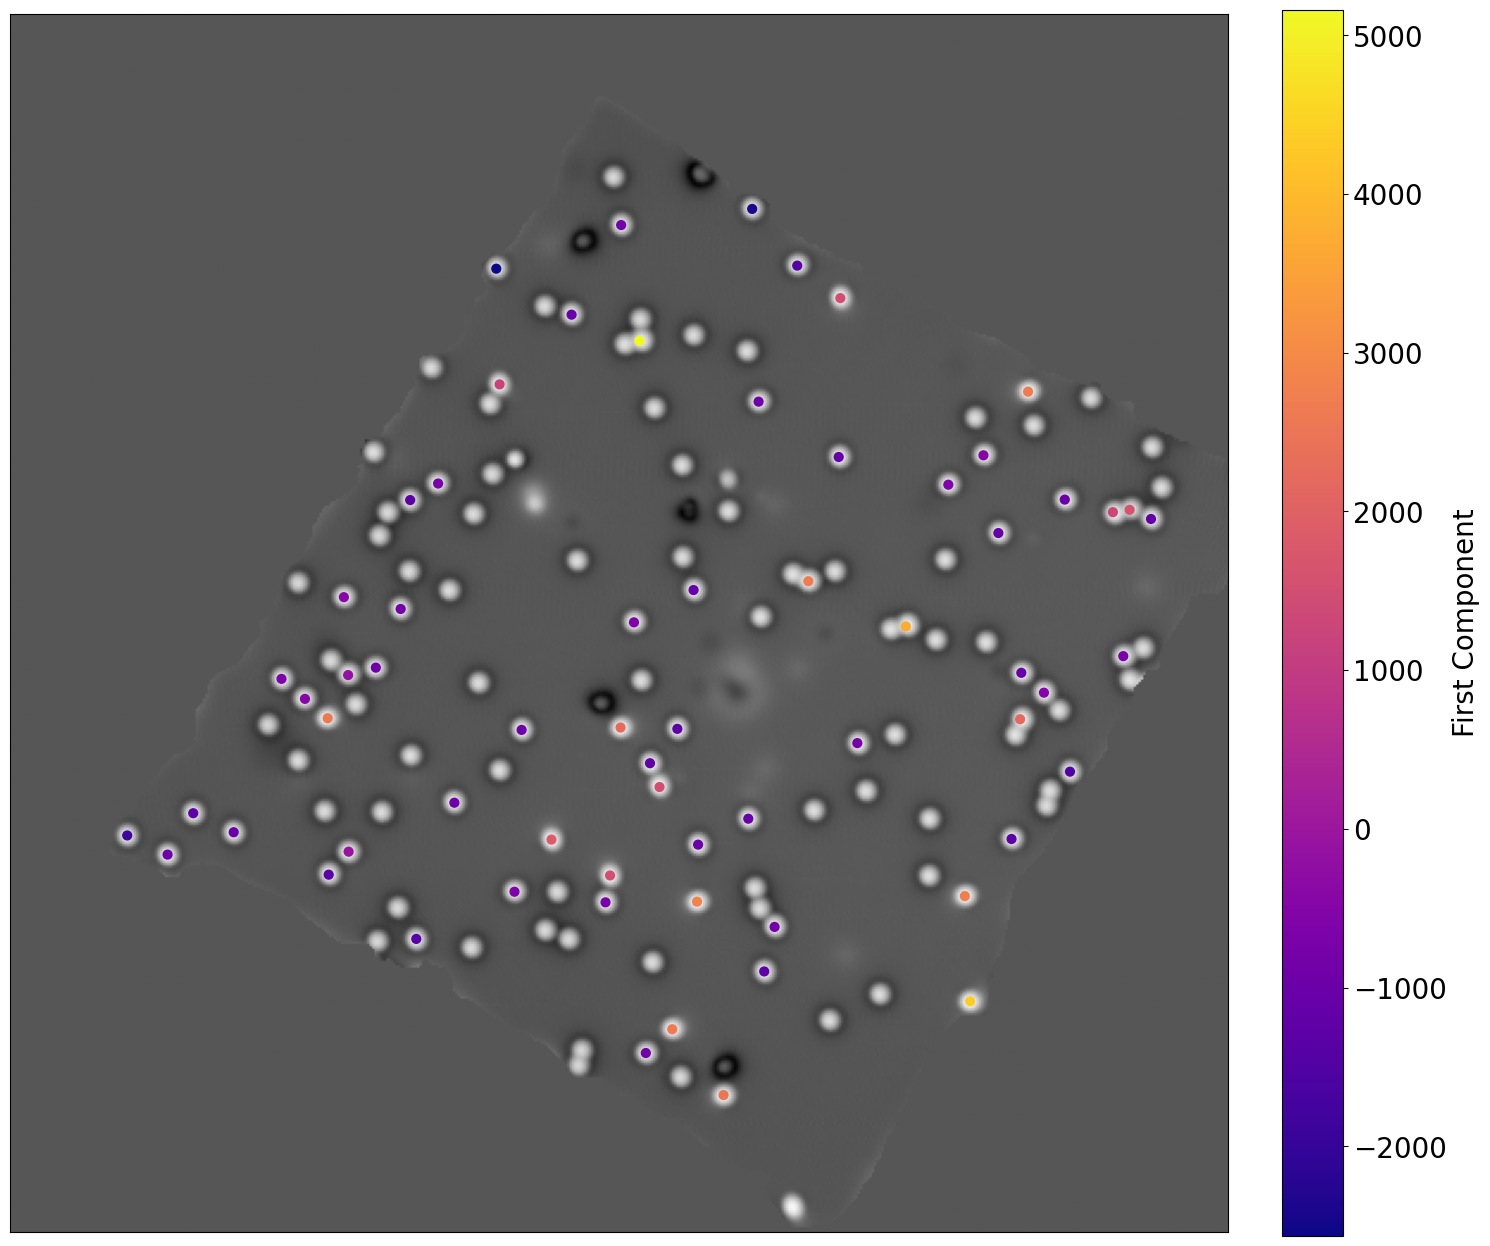

In [174]:
# Project the first principal component onto the Ti-classified data
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=pca_load[:,0], s=40,
            cmap="plasma")
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.set_label("First Component", fontsize = 20)
cbar.ax.tick_params(labelsize=20)
#plt.title("PCA Analysis of Ti Sites: PCA1")
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.tight_layout()
plt.show()

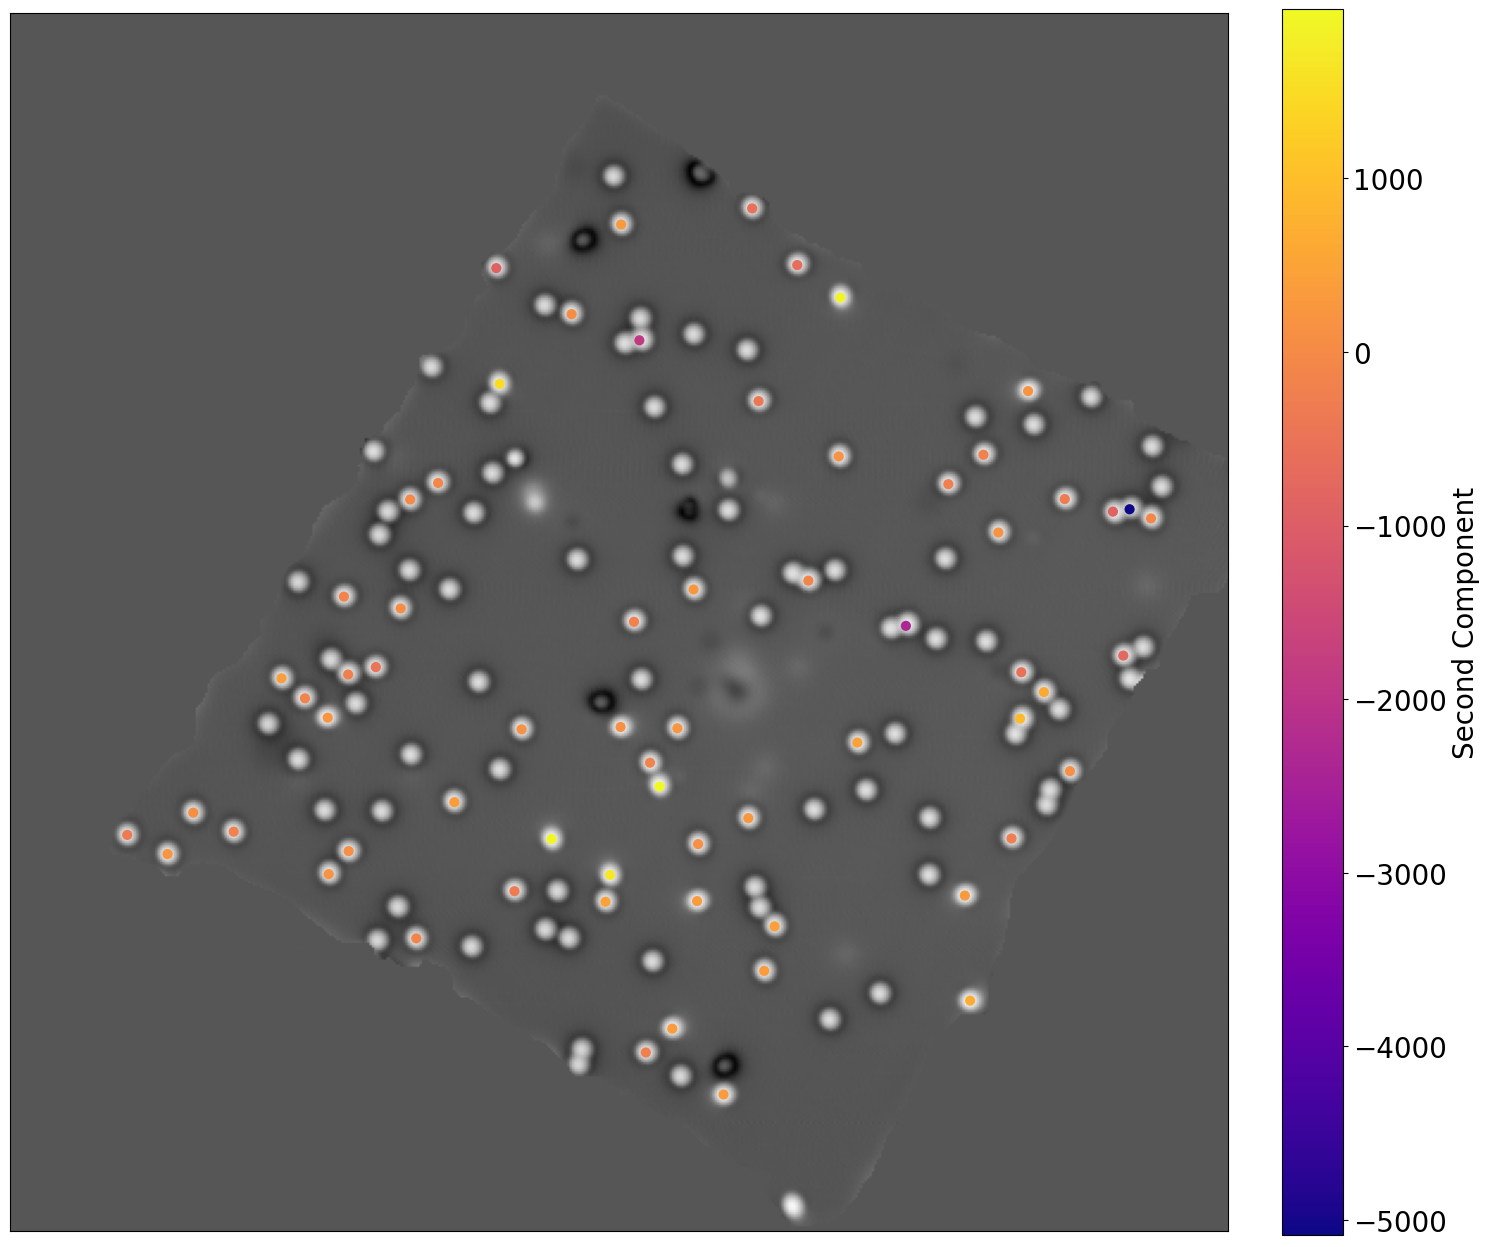

In [175]:
# Project the second principal component onto the Ti-classified data
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=pca_load[:,1], s=40,
            cmap="plasma")
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.set_label("Second Component", fontsize = 20)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
#plt.title("PCA Analysis of Ti Sites: PCA2")
plt.tight_layout()
plt.show()

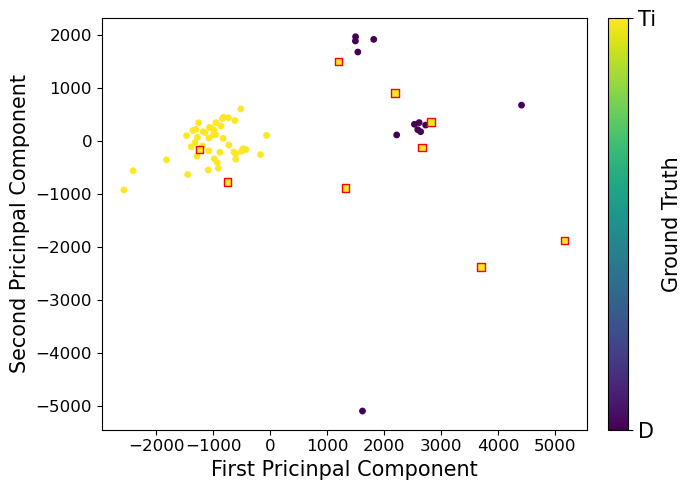

In [176]:
# Plot the two-component PCA space and colorize by the ground truth labeling 
fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = ti_numeric, cmap = 'viridis', s = 15)
error = ax.scatter(pca_load[error_indices,0], pca_load[error_indices,1], c = ti_numeric[error_indices], cmap = 'viridis',
                marker='s', s=30, edgecolors='red', vmin = ti_numeric.min(), vmax = ti_numeric.max())
ax.set_xlabel('First Pricinpal Component', fontsize=15)
ax.set_ylabel('Second Pricinpal Component', fontsize=15)
cbar = plt.colorbar(scatter_plot, ax=ax, fraction=0.046, pad=0.04)
cbar.set_ticks(np.arange(len(ti_labels)))
cbar.set_ticklabels(ti_labels, fontsize = 15)
cbar.set_label("Ground Truth", fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Computation of distances started
Computation of the distances up to 10 NNs started
0.24 seconds for computing distances
ID estimation finished: selecting ID of 6.244407090030162
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished


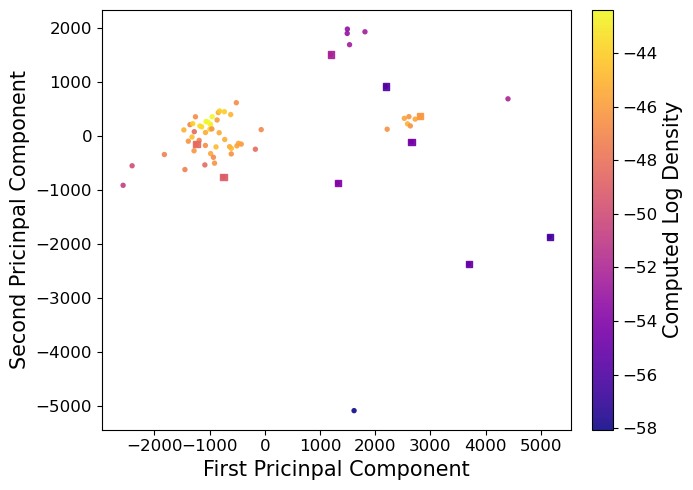

In [177]:
# Find and plot clusters in the data based on the computed density profile of the Ti-class dataset
data = Data(X_vec_Ti, verbose=True)
data.compute_distances(maxk=10)
data.compute_id_2NN()
data.compute_density_kstarNN()
fig, ax = plt.subplots(figsize = (7,5))
ax.set_xlabel('First Pricinpal Component', fontsize = 15)
ax.set_ylabel('Second Pricinpal Component', fontsize = 15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
scatter = ax.scatter(pca_load[:, 0], pca_load[:, 1], s=15.0, alpha=0.9, c=data.log_den, linewidths=0.0, cmap = 'plasma')
error = ax.scatter(pca_load[error_indices,0], pca_load[error_indices,1], c = data.log_den[error_indices],
                marker='s', s=20, alpha = 0.9, cmap = 'plasma', vmin = data.log_den.min(), vmax = data.log_den.max())
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Computed Log Density", fontsize = 15)
plt.tight_layout()
plt.show()

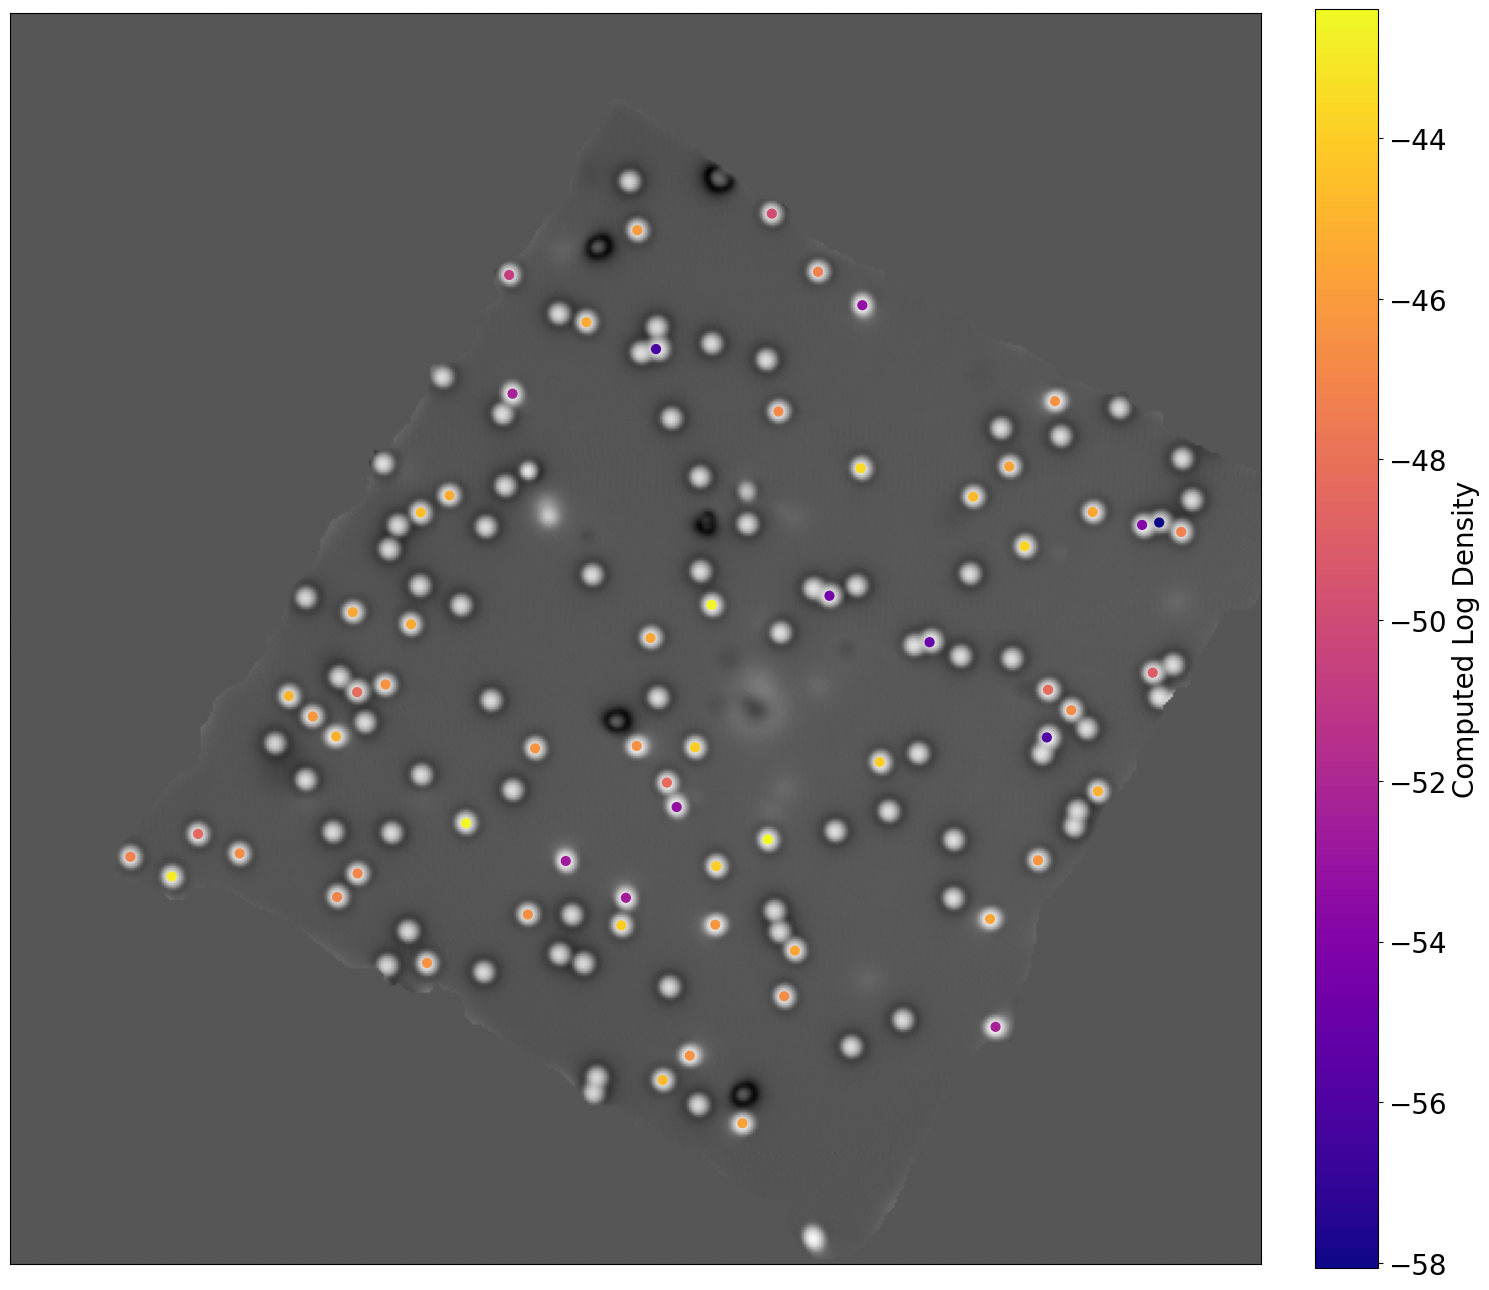

In [178]:
# Project the density-based clustering results on the Ti-classified data
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=data.log_den, s=40,
            cmap="plasma")
im = plt.imshow(expdata, cmap = 'gray')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.set_label("Computed Log Density", fontsize = 20)
#plt.title("Density Clustering Results of Ti PCA Space")
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.tight_layout()
plt.show()


In [179]:
# Find the distance of each Ti-classified data point to its nearest neighbour
Ti_dist_matrix = distance_matrix(training_coordinates, training_coordinates)
Ti_dist_matrix[Fe_indices] = 0
Ti_dist_matrix[Ti_dist_matrix == 0] = np.inf
nearest_neighbours = Ti_dist_matrix.min(axis = 1)
nearest_neighbours = nearest_neighbours[np.isfinite(nearest_neighbours)]

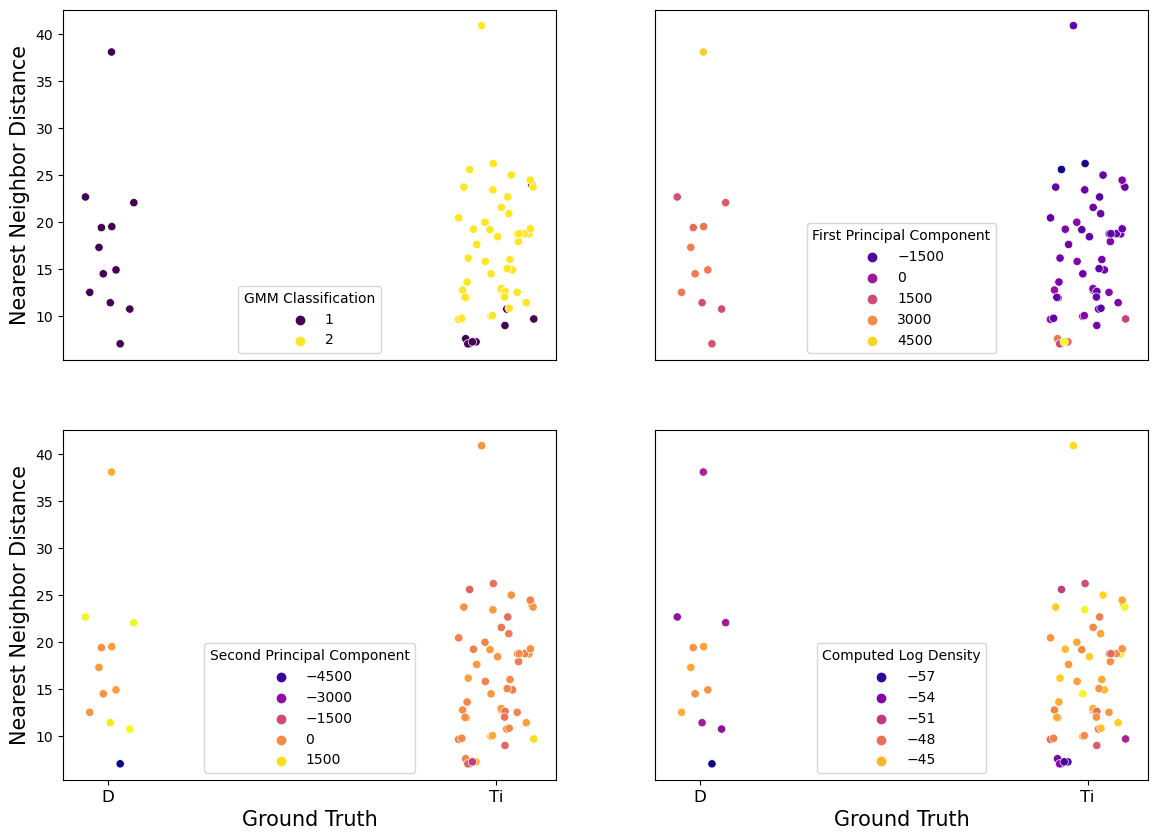

In [180]:
# Plot the nearest neighbour distance against the ground truth labeling colorized by class-conditioned GMM classification,
# the first principal component, the second princpal component, and the density-based clustering result
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

np.random.seed(0)
axs[0][0] = sns.scatterplot(x = ti_numeric + np.random.uniform(-0.1, 0.1,len(ti_numeric)), 
                y = nearest_neighbours, hue = ti_ft_classes, 
                palette = 'viridis', ax= axs[0][0])
#axs[0][0].set_xticks(ticks = np.unique(ti_numeric), labels = np.unique(ti_labels), fontsize = 12)
axs[0][0].set_ylabel('Nearest Neighbor Distance', fontsize=15)
handles, labels = axs[0][0].get_legend_handles_labels()
axs[0][0].get_xaxis().set_visible(False)
axs[0][0].legend(handles, labels,  loc='lower center', title = 'GMM Classification')

np.random.seed(0)
axs[0][1] = sns.scatterplot(x = ti_numeric + np.random.uniform(-0.1, 0.1,len(ti_numeric)), 
                y = nearest_neighbours, hue = pca_load[:,0], 
                palette = 'plasma', ax= axs[0][1])
#axs[0][1].set_xticks(ticks = np.unique(ti_numeric), labels = np.unique(ti_labels), fontsize = 12)
axs[0][1].get_yaxis().set_visible(False)
axs[0][1].get_xaxis().set_visible(False)
axs[0][1].legend(title = 'First Principal Component')

np.random.seed(0)
axs[1][0] = sns.scatterplot(x = ti_numeric + np.random.uniform(-0.1, 0.1,len(ti_numeric)), 
                y = nearest_neighbours, hue = pca_load[:,1], 
                palette = 'plasma', ax= axs[1][0])
axs[1][0].set_xticks(ticks = np.unique(ti_numeric), labels = np.unique(ti_labels), fontsize = 12)
axs[1][0].set_ylabel('Nearest Neighbor Distance', fontsize=15)
axs[1][0].set_xlabel('Ground Truth', fontsize=15)
axs[1][0].legend(title = 'Second Principal Component')


np.random.seed(0)
axs[1][1] = sns.scatterplot(x = ti_numeric + np.random.uniform(-0.1, 0.1,len(ti_numeric)), 
                y = nearest_neighbours, hue = data.log_den, 
                palette = 'plasma', ax= axs[1][1])
axs[1][1].set_xticks(ticks = np.unique(ti_numeric), labels = np.unique(ti_labels), fontsize = 12)
axs[1][1].set_xlabel('Ground Truth', fontsize=15)
axs[1][1].get_yaxis().set_visible(False)
axs[1][1].legend(title = 'Computed Log Density')